# Stock Price Analysis Price Prediction with Random Forest Model #

## 1. Introduction
The financial markets, characterised by their dynamic and unpredictable nature, have long been a subject of fascination and scrutiny for investors, analysts… In the quest to comprehend and estimate market trends, machine learning models have emerged as powerful tools, providing a data-driven approach to forecasting stock prices. In the realm of machine learning, the Random Forest (RF) algorithm stands out for its versatility and robustness, making it an intriguing candidate for predicting stock prices.

Our research aims to leverage the capabilities and measure performance of the Random Forest model in the context of prediction of stock market dynamics, utilising the "**NASDAQ 100, S&P 500, QQQ, SPY**" dataset as a comprehensive source of historical market data. The dataset, sourced from Kaggle, encompasses a wealth of information about stock prices, volumes, and other relevant financial indicators. 

Each of the four datasets presents unique characteristics and offers distinct insights into the financial markets. The NASDAQ 100 dataset is particularly valuable for understanding the technology sector, as it primarily represents technology-based stocks. The S&P 500 dataset provides a more generalised view, covering a wide range of industries and reflecting the overall performance of the U.S. economy. The QQQ dataset, representing an ETF that tracks the NASDAQ 100 index, is a crucial tool for gauging the tech sector's performance, particularly influential tech giants. In contrast, the SPY dataset focuses on another ETF, tracking the S&P 500 index, offering a broader perspective on the large-cap U.S. stock market. The inclusion of ETFs like QQQ and SPY provides a more comprehensive understanding of market dynamics and investor behaviour, as these ETFs are commonly used for both speculative trading and long-term investment strategies.

By exploring these datasets through the lens of the Random Forest model, this project aims to uncover patterns and predict stock prices, enhancing our understanding of market dynamics through sophisticated data analysis and visualisation techniques.

## 2. Research Question
The central research question guiding our investigation is: 

***How does the performance of the Random Forest regression model vary across different stock markets in terms of next-day closing price, and what insights does this provide into the efficacy of machine learning in stock market prediction?***

To address this question, our research is structured with the following key objectives:

* Acquire and preprocess datasets from four diverse stock markets with the use of API to ensure a representative and comprehensive analysis.
* Create a Random Forest model and test for each market, training on historical data. 
* Assess predictive accuracy using relevant performance metrics.
* Analyse the unique features and dynamics of each stock market to discern patterns that may impact the model's performance.
* Compare the accuracy of the Random Forest model across the selected stock markets, identifying commonalities and differences.

*All necessary modules and packages are imported at the beginning:*

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import datetime
from sklearn import tree
import pygal
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 3. Data Importing

We use Kaggle API to import datasets. After downloading the API token in kaggle.json, we save kaggle.json under the path **~/.kaggle/kaggle.json** to make sure the API works. 

Same steps should be taken for all other laptops/PCs to make sure the datasets can be imported and following code can be run.

In [61]:
# import data using kaggle API
# kaggle API token must be in ~/.kaggle/kaggle.json

api = KaggleApi()
api.authenticate()
# download and unzip data in current directory
api.dataset_download_files('guillemservera/sp500-nasdaq-spy-qqq-ohlcv-data', path='./', unzip=True)

## 4. Data Cleaning


In order to prepare our raw datasets for analysis, we perform a series of data cleaning/preprocessing steps. These steps ensure that our data is in a clean and structured format, making it suitable for further analysis and modeling.

1. **Reading the Data**: We begin by reading the data from the specified file path using the Pandas library.

2. **Copying the DataFrame**: A copy of the DataFrame is created to work with, ensuring that original data files remain unchanged.

3. **Date Conversion**: We convert the 'date' column to a datetime format to enable time-based analysis.

4. **Handling Adjusted Close Price**: If the dataset includes an 'adjusted_close' column, we use it as the 'close' price, as it accounts for dividends and splits and reflect better valuation. We then drop the 'close' column.

5. **Calculating Moving Averages**: We calculate the average closing prices over different time periods (5 days, 10 days, and 20 days) to use as features for predictive modeling.

6. **Creating Target Variable**: We create a 'close_nextday' column by shifting the 'close' price one day ahead. This will serve as our target variable for predictive modeling.

7. **Removing NaN Values**: We remove any rows with missing values (NaN) that may be in the original datasets or have been generated during the rolling average calculations.

8. **Filtering Zero Volume Rows**: To ensure data quality, we remove rows where the 'volume' column has a value of 0, as such rows may not be informative for analysis and stock price prediction.

In [3]:
def data_preprocess(filepath):
    """Data cleaning and preprocessing for 4 raw datasets."""
    df = pd.read_csv(filepath)
    df = df.copy()
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    df = df.set_index('date')
    # when adjusted close price that considers dividends and splits is available
    # use it as close price and drop close column for better valuation
    if 'adjusted_close' in df.columns:
        df.drop('close', axis=1, inplace=True)
        df.rename(columns={'adjusted_close':'close'}, inplace=True)
    # average moving prices and next day closing price for RF model
    df['avg_pri_5d']=df['close'].rolling(5).mean( )
    df['avg_pri_10d']=df['close'].rolling(10).mean( )
    df['avg_pri_20d']=df['close'].rolling(20).mean( )
    df['close_nextday'] = df['close'].shift(-1)
    df.dropna(inplace=True)
    df = df[df['volume'] != 0] # remove rows with volume = 0
    return df

## 5. Descriptive Analysis

In the realm of financial markets, where volatility and complexity are the norm, data analysis plays a pivotal role in providing valuable insights. Dscriptive analysis is not merely a preliminary step but rather a cornerstone in our quest to gain deeper insights into the dynamics of different stock markets and the performance of the Random Forest model.

**Understanding Market-Specific Patterns**: Descriptive analysis enables us to delve into the historical data of each stock index, revealing market-specific trends, anomalies, and behaviors. This comprehensive understanding is essential for evaluating how machine learning models like Random Forest perform across diverse market landscapes.

**Performance Context**: Through descriptive analysis, we gain valuable context regarding unique features and dynamics of each index for assessing the performance of Random Forest model. It allows us to identify historical trends, market volatility, and influential factors that may influence the model's predictive accuracy.

**Comparative Insights**: Our research involves the comparison of the Random Forest model's performance across four distinct stock markets. Descriptive analysis serves as the lens through which we explore and compare these markets, highlighting similarities and differences that can provide critical insights into the efficacy of machine learning in stock market prediction.

We start with conducting general descriptive analysis on the 4 processed datasets to have a basic picture about our data:

In [4]:
SP500 = data_preprocess('SP500.csv')
# SP500.head()
SP500.describe()

open          high           low         close        volume  \
count  18632.000000  18632.000000  18632.000000  18632.000000  1.863200e+04   
mean     786.711509    791.398275    781.747453    786.882291  1.134753e+09   
std     1050.461163   1056.367020   1044.191677   1050.677439  1.713567e+09   
min       16.660000     16.660000     16.660000     16.660000  6.800000e+05   
25%       88.655000     89.410000     87.852500     88.655000  1.025000e+07   
50%      248.640000    250.170000    246.475000    248.745000  1.365700e+08   
75%     1211.875000   1219.830000   1204.550000   1212.212425  1.869000e+09   
max     4804.509800   4842.069800   4785.870100   4839.810100  1.145623e+10   

       change_percent   avg_vol_20d    avg_pri_5d   avg_pri_10d   avg_pri_20d  \
count    18632.000000  1.863200e+04  18632.000000  18632.000000  18632.000000   
mean         0.035339  1.132841e+09    786.369417    785.731080    784.460996   
std          0.992610  1.678421e+09   1049.810428   1048.757367   1046.677366   
min        -20.470000  6.300000e+04     16.674000     16.626000     16.578000   
25%         -0.410000  1.054825e+07     88.722000     88.700750     88.662375   
50%          0.050000  1.446752e+08    248.449000    248.272000    247.818000   
75%          0.510000  1.925979e+09   1211.074500   1207.595230   1206.195725   
max         11.580000  7.701906e+09   4785.614080   4769.074070   4756.815070   

       close_nextday  
count   18632.000000  
mean      787.141725  
std      1051.083945  
min        16.670000  
25%        88.682500  
50%       248.760000  
75%      1212.302500  
max      4850.430200

In [5]:
ND100 = data_preprocess('NASDAQ_100.csv')
# ND100.head()
ND100.describe()

open          high           low         close        volume  \
count   9638.000000   9638.000000   9638.000000   9638.000000  9.638000e+03   
mean    3168.646130   3194.605344   3141.386958   3169.501282  1.676420e+09   
std     3902.004767   3931.175027   3871.041495   3903.264640  1.360436e+09   
min      113.800000    113.910000    113.205000    113.820000  3.174000e+07   
25%      469.745000    475.745000    466.965000    470.945000  4.869100e+08   
50%     1682.550050   1696.930000   1666.435000   1679.830050  1.682780e+09   
75%     3974.509950   4004.460100   3937.799925   3969.272550  2.098240e+09   
max    17060.140600  17317.210900  17041.849600  17314.000000  1.162119e+10   

       change_percent   avg_vol_20d    avg_pri_5d   avg_pri_10d   avg_pri_20d  \
count     9638.000000  9.638000e+03   9638.000000   9638.000000   9638.000000   
mean         0.065720  1.671195e+09   3165.986763   3161.651623   3153.070739   
std          1.647714  1.315949e+09   3897.848116   3891.432459   3878.899444   
min        -15.080000  1.248480e+08    114.299000    112.717500    111.476000   
25%         -0.670000  4.870199e+08    468.690000    462.642250    456.612500   
50%          0.120000  1.746993e+09   1681.632010   1681.303000   1677.809505   
75%          0.840000  2.059434e+09   3972.866445   3947.772000   3939.333409   
max         18.770000  8.052748e+09  16939.239840  16794.469920  16736.888580   

       close_nextday  
count    9638.000000  
mean     3171.287539  
std      3905.804854  
min       113.820000  
25%       473.185000  
50%      1679.890050  
75%      3969.830025  
max     17330.380900

In [6]:
SPY = data_preprocess('SPY.csv')
# SPY.head()
SPY.describe()

open         high          low        volume        close  \
count  7780.000000  7780.000000  7780.000000  7.780000e+03  7780.000000   
mean    171.263154   172.293840   170.128646  8.476974e+07   142.901489   
std     107.211342   107.785293   106.610159  9.233801e+07   113.143427   
min      43.343800    43.875000    43.281300  5.200000e+03    24.650300   
25%     105.797500   106.617500   104.822500  1.025595e+07    70.824400   
50%     132.408100   133.203750   131.285600  6.352987e+07    93.672300   
75%     210.625000   211.322500   209.722575  1.163508e+08   181.611825   
max     479.220000   482.720000   476.537400  8.715469e+08   482.430000   

       change_percent   avg_vol_20d   avg_pri_5d  avg_pri_10d  avg_pri_20d  \
count     7780.000000  7.780000e+03  7780.000000  7780.000000  7780.000000   
mean         0.044982  8.466832e+07   142.785055   142.640125   142.352095   
std          1.181610  8.510360e+07   113.017901   112.866495   112.567663   
min        -10.940000  7.584500e+04    24.845500    24.790420    25.026235   
25%         -0.450000  9.548619e+06    70.727380    70.610748    70.370795   
50%          0.070000  6.867248e+07    93.545090    93.545485    93.420578   
75%          0.600000  1.182510e+08   181.289925   180.906662   180.701130   
max         14.520000  5.389658e+08   476.564000   475.213000   473.981000   

       close_nextday  
count    7780.000000  
mean      142.960403  
std       113.201396  
min        24.650300  
25%        70.839250  
50%        93.702000  
75%       181.620475  
max       483.450000

In [7]:
QQQ = data_preprocess('QQQ_raw.csv')
# QQQ.head()
QQQ.describe()

open         high          low        volume        close  \
count  6238.000000  6238.000000  6238.000000  6.238000e+03  6238.000000   
mean    116.240493   117.223319   115.154417  6.654728e+07   107.570215   
std     101.005824   101.783978   100.176453  4.964363e+07   101.673962   
min      19.940000    20.530000    19.760000  1.651000e+06    17.157900   
25%      41.985000    42.322500    41.555000  3.099185e+07    36.359675   
50%      70.290000    70.677500    69.675000  5.514683e+07    59.789550   
75%     159.500000   160.958300   157.677975  8.886444e+07   145.365500   
max     415.220000   421.340000   414.630000  6.167953e+08   421.180000   

       change_percent   avg_vol_20d   avg_pri_5d  avg_pri_10d  avg_pri_20d  \
count     6238.000000  6.238000e+03  6238.000000  6238.000000  6238.000000   
mean         0.049849  6.683491e+07   107.452278   107.306431   107.017064   
std          1.725385  4.349456e+07   101.513293   101.323872   100.954725   
min        -11.980000  7.094280e+06    17.358020    17.774560    18.192395   
25%         -0.670000  3.356189e+07    36.383065    36.362053    36.330574   
50%          0.110000  5.598974e+07    59.550850    59.303140    59.323475   
75%          0.820000  9.004667e+07   144.768380   144.077798   142.949021   
max         16.840000  3.326542e+08   412.092000   408.576000   407.226680   

       close_nextday  
count    6238.000000  
mean      107.630276  
std       101.748849  
min        17.157900  
25%        36.359675  
50%        59.798500  
75%       145.470725  
max       421.730000

From the general description, a basic observation is that different indices perform very differently -- this could be due to their nature, such as variations in timeframes and the composition of stocks. Clearer performance distinctions can be observed when we visualise these trends.

### 5.1 Descriptive Data Visualization

We start with visualising the trends of closing prices for different indices, as this is the most important parameter that we care about stock price prediction, i.e., we are predicting next-day closing prices.

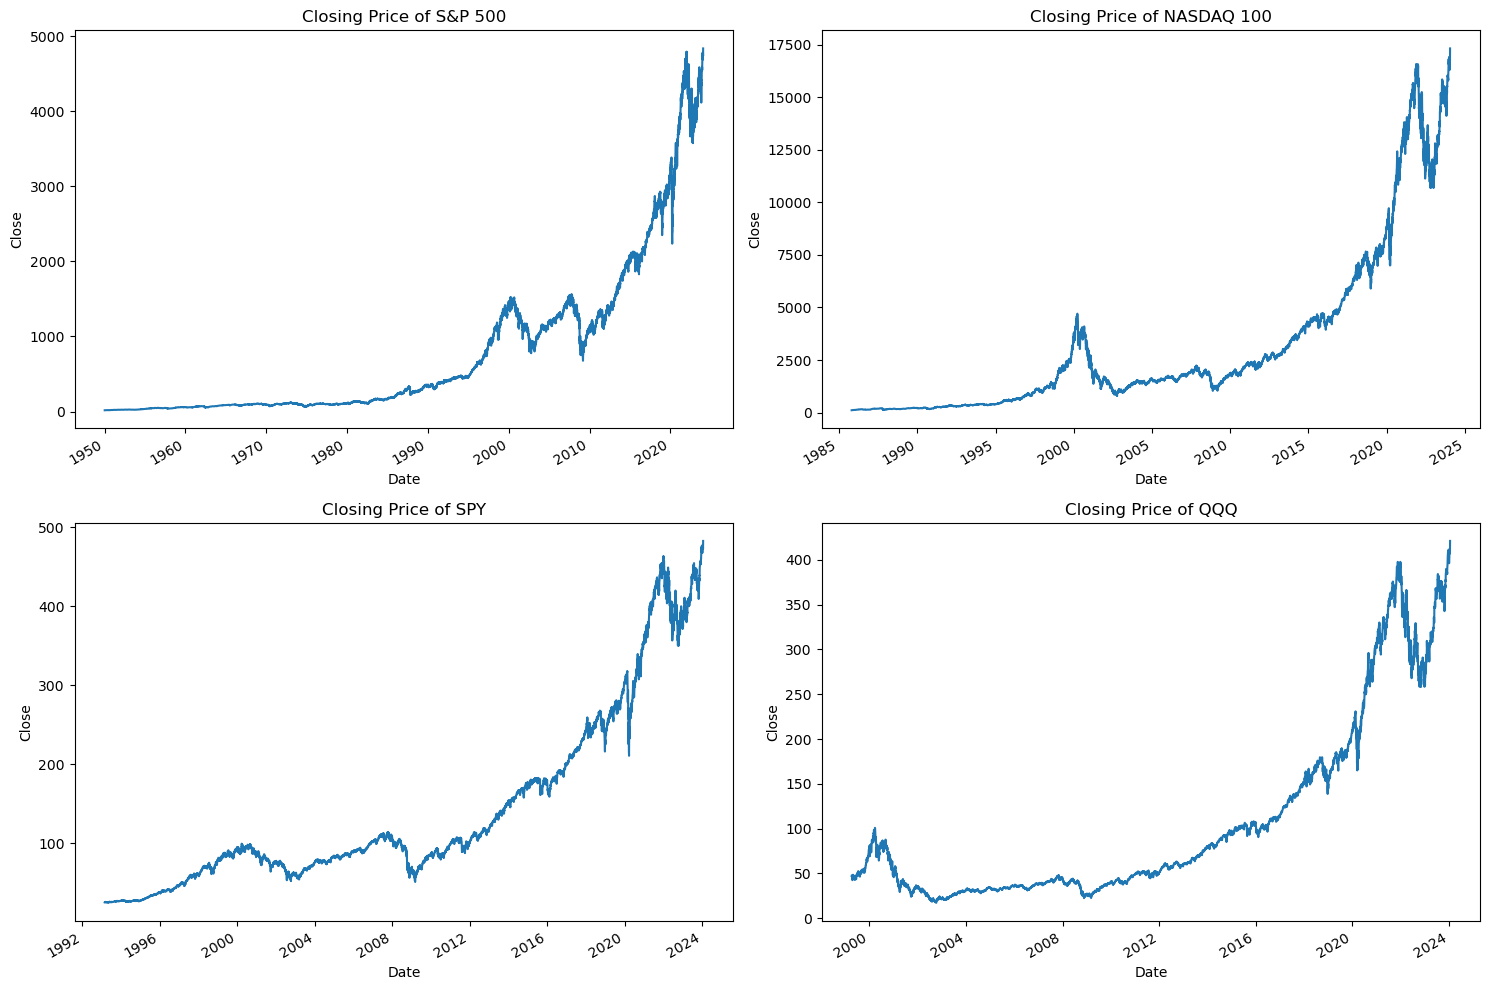

In [105]:
index_list = [SP500, ND100, SPY, QQQ]
label_list = ['S&P 500', 'NASDAQ 100', 'SPY', 'QQQ']

plt.figure(figsize=(15, 10))

for i, index in enumerate(index_list, 1):
    plt.subplot(2, 2, i)
    index['close'].plot()
    plt.ylabel('Close')
    plt.xlabel('Date')
    plt.title(f"Closing Price of {label_list[i - 1]}")

plt.tight_layout()
plt.style.use('default')
plt.show()

Upon closer examination of the charts, it becomes evident that the closing prices of S&P 500, NASDAQ 100, and SPY before the year 1995 exhibit predominantly flat and stable trends. This historical data, given its limited variability and relevance, contributes minimally to the stock prediction process. Furthermore, the QQQ dataset itself commences from March 10, 1999. To maintain data consistency across all datasets and focus our analysis on more meaningful trends, we have chosen to use January 1, 2000, as the starting date for our analysis. This decision aligns with our belief that utilising data from the 21st century provides more relevant and insightful information for stock prediction.

In [9]:
# filter data from 2000-01-01 as the start of 21st century, but actually 2000-01-03 is the first trading day
SP500_new = SP500.loc['2000-01-01':]
ND100_new = ND100.loc['2000-01-01':]
SPY_new = SPY.loc['2000-01-01':]
QQQ_new = QQQ.loc['2000-01-01':]
# SP500_new.head()
# ND100_new.head()
# SPY_new.head()
# QQQ_new.head()

We then concatenate the dataframes into one for the following visualisation. We add a 'Stock Index' column in the concatenated dataframe to distinguish rows of each index. To have a basic picture of what the concatenated dataframe will look like, we display data from year 2023 as an example.

In [10]:
# add stock index column
SP500_new['Stock Index'] = 'S&P 500'
ND100_new['Stock Index'] = 'NASDAQ 100'
SPY_new['Stock Index'] = 'SPY'
QQQ_new['Stock Index'] = 'QQQ'
# concatenate the DataFrames
combined_df = pd.concat([SP500_new, ND100_new, SPY_new, QQQ_new])

# reorder the columns to bring 'Stock Index' to the front
column_order = ['Stock Index'] + [col for col in combined_df.columns if col != 'Stock Index']
combined_df = combined_df[column_order]
# display 2023 data as an example
display(combined_df[combined_df.index.year == 2023])

Stock Index       open       high        low      close  \
date                                                                 
2023-01-03     S&P 500  3853.2900  3878.4600  3794.3301  3824.1399   
2023-01-04     S&P 500  3840.3601  3873.1599  3815.7700  3852.9700   
2023-01-05     S&P 500  3839.7400  3839.7400  3802.4199  3808.1001   
2023-01-06     S&P 500  3823.3701  3906.1899  3809.5601  3895.0801   
2023-01-09     S&P 500  3910.8201  3950.5701  3890.4199  3892.0901   
...                ...        ...        ...        ...        ...   
2023-12-22         QQQ   409.0000   409.9700   406.4787   408.1655   
2023-12-26         QQQ   409.2500   411.5600   409.1500   410.6640   
2023-12-27         QQQ   410.9500   411.7900   410.0800   411.5000   
2023-12-28         QQQ   412.6700   412.9200   410.9400   411.3000   
2023-12-29         QQQ   411.2800   411.6400   407.5800   409.5200   

                volume  change_percent   avg_vol_20d  avg_pri_5d  avg_pri_10d  \
date                                                                            
2023-01-03  3959140000           -0.40  4.033436e+09  3825.07798   3831.03198   
2023-01-04  4414080000            0.75  4.040099e+09  3829.82198   3834.56299   
2023-01-05  3893450000           -1.16  4.016352e+09  3834.79800   3833.21099   
2023-01-06  3923560000            2.28  4.006628e+09  3843.95802   3834.87501   
2023-01-09  4311770000           -0.08  4.021872e+09  3854.47604   3841.84503   
...                ...             ...           ...         ...          ...   
2023-12-22    34314000            0.15  4.522905e+07   406.88018    403.60098   
2023-12-26    22722500            0.61  4.465819e+07   407.63974    405.21494   
2023-12-27    31980500            0.20  4.448266e+07   408.15072    406.59829   
2023-12-28    27029200           -0.05  4.389353e+07   409.83706    407.45592   
2023-12-29    42633400           -0.43  4.338348e+07   410.22990    408.17046   

            avg_pri_20d  close_nextday  
date                                    
2023-01-03  3891.793495      3852.9700  
2023-01-04  3884.499990      3808.1001  
2023-01-05  3877.841995      3895.0801  
2023-01-06  3875.900005      3892.0901  
2023-01-09  3872.329010      3919.2500  
...                 ...            ...  
2023-12-22   395.771005       410.6640  
2023-12-26   396.894685       411.5000  
2023-12-27   398.009295       411.3000  
2023-12-28   399.132855       409.5200  
2023-12-29   400.216290       402.5900  

[1000 rows x 12 columns]

Now as we have sychronised timeframe for all datasets, we can conduct several comparisons and closer observation. We compare **sales volum** first.

Distinctively, the S&P 500 and NASDAQ 100, as broad-market indices encompassing a wide range of sectors and predominantly featuring tech giants, collectively contribute to substantial trading volumes. On the contrary, notable lower volumes are witnessed for QQQ and SPY due to their ETF nature. While S&P 500, QQQ, and SPY saw peak volumes post-global financial crisis, the NASDAQ 100 exhibited a distinct trend. This divergence can be attributed to the NASDAQ 100's unique composition, consisting solely of **non-financial corporations**, making it less vulnerable to the crisis's impact. Nevertheless, QQQ, tracking the NASDAQ 100, experienced different fluctuations, reflecting ETF trading dynamics. Additionally, both the NASDAQ 100 and S&P 500 surged in volume post-Covid-19, driven by their substantial tech company presence, especially in the NASDAQ 100.



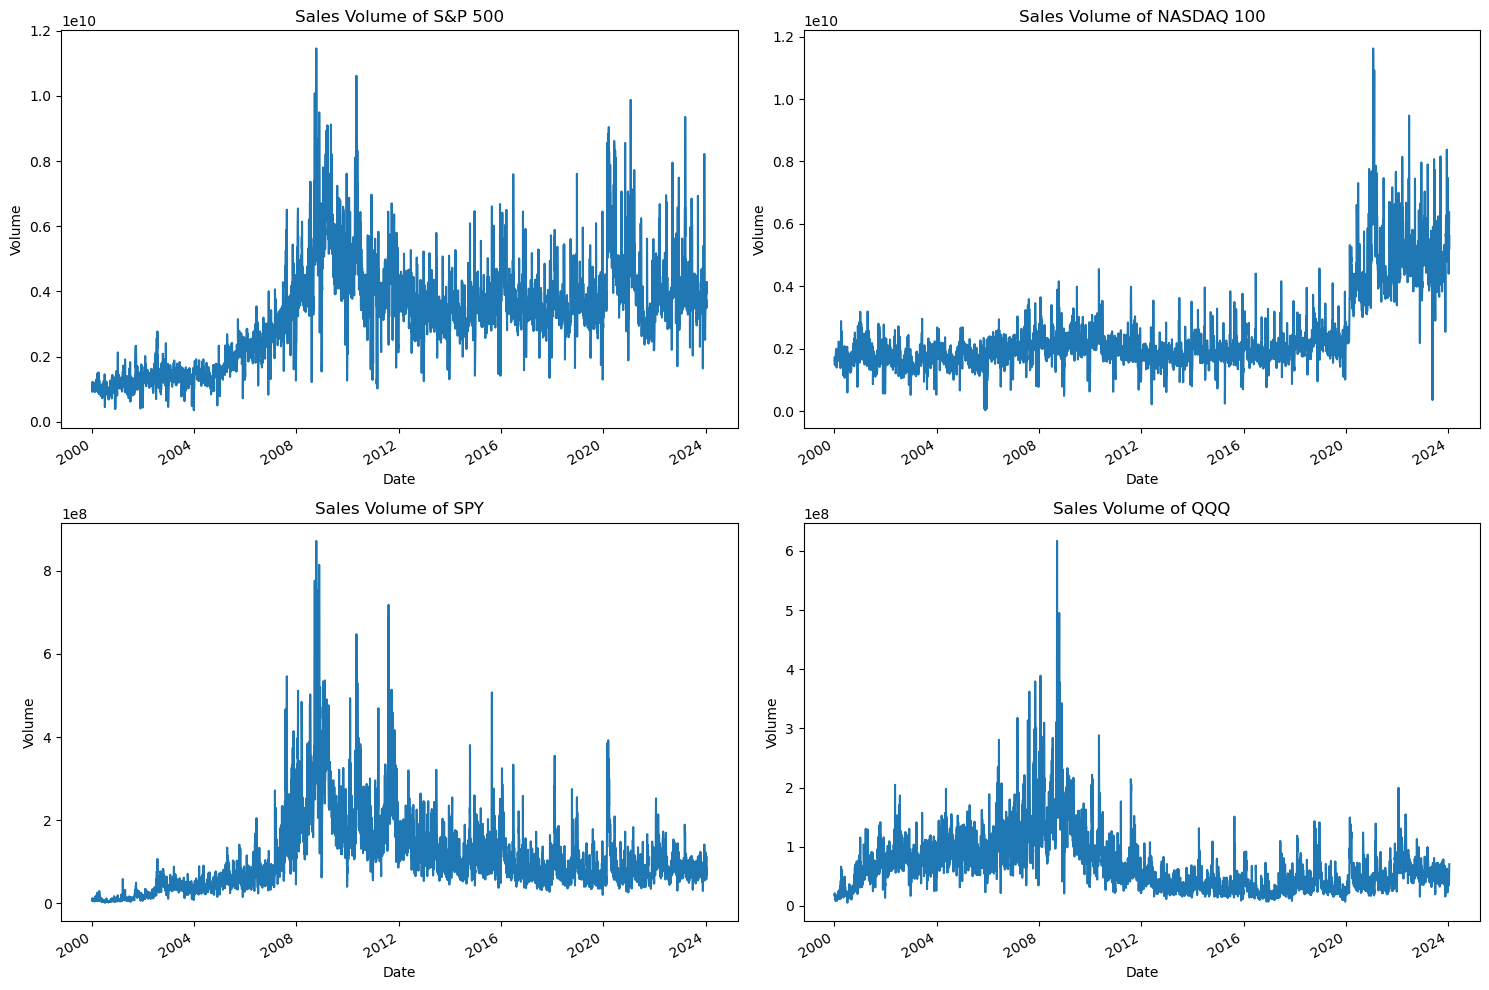

In [106]:
# compare sales volume, plot indivudially to see twists and turns
plt.figure(figsize=(15, 10))

for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2, 2, i)
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    filtered_df['volume'].plot()   
    plt.ylabel('Volume')
    plt.xlabel('Date')
    plt.title(f"Sales Volume of {stock_index}")

plt.tight_layout()
plt.show()

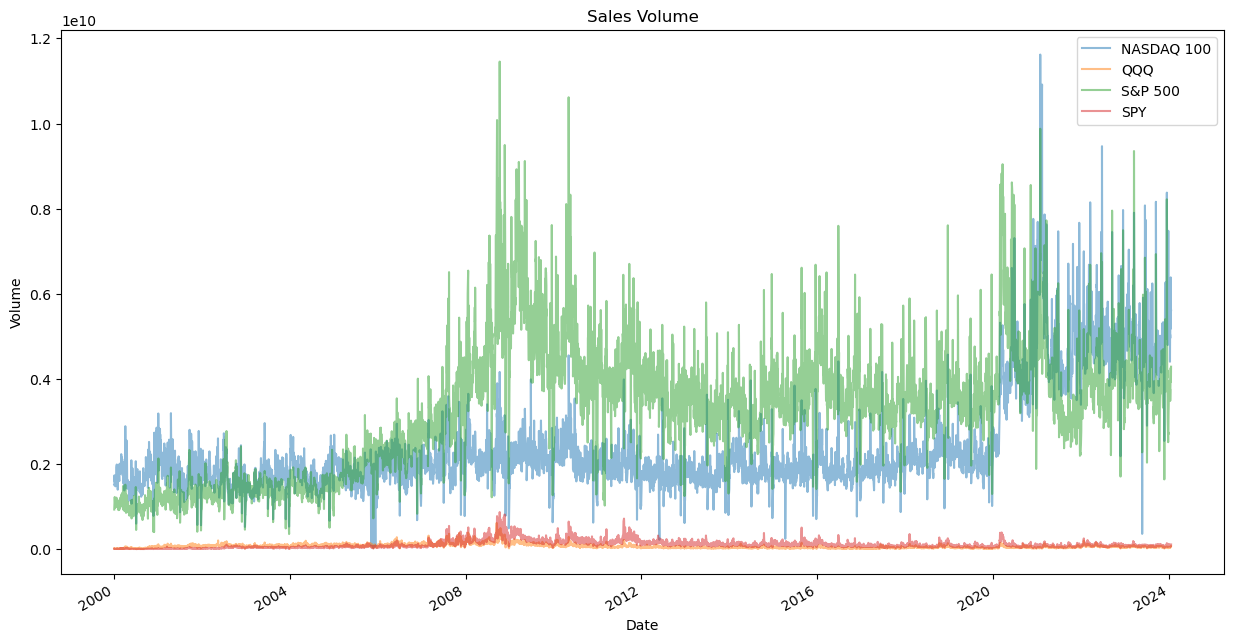

In [107]:
# compare sales volume in one plot to see overall volumes
plt.figure(figsize=(15, 8))
combined_df.groupby('Stock Index').volume.plot(legend=True, alpha=0.5)
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title('Sales Volume')
plt.show()

We then delve into the nuanced dynamics of the market as reflected in the **moving averages** of four indices. As price levels differ significantly for different indices, we take log scale on all prices for more meaningful comparison. We observe the inflection points that align with pivotal economic events, such as market downturns and recoveries. The moving averages serve as a smoothed representation of market trends, and closing prices' deviations from these averages during key periods like the global financial crisis and COVID-19 pandemic provide critical insights into market behaviour.

We note that while moving averages follow the general trajectory of the closing prices, their divergence at certain intervals may hold predictive power. In our analysis, we leverage these discrepancies as input for a Random Forest algorithm -- incorporating moving averages as predictors in a Random Forest model enhances its capability to forecast future stock prices, supporting the hypothesis that historical trends, when appropriately analysed, can be indicative of future movements.

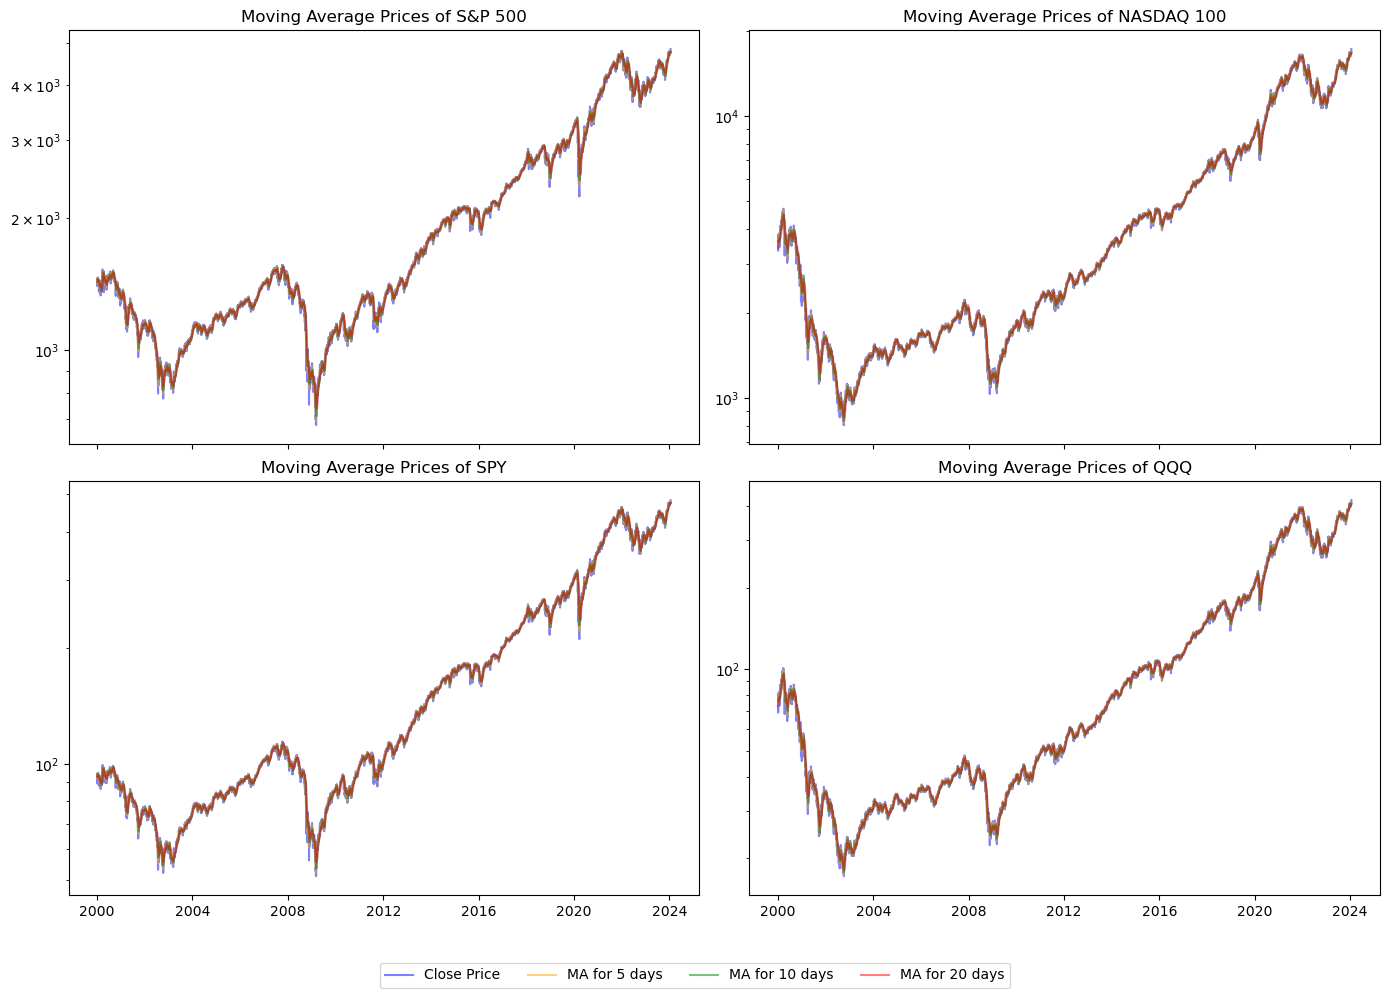

In [108]:
# compare moving average prices
# use log scale for better comparison

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for ax, stock_index in zip(axes, label_list):
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    
    ax.plot(filtered_df.index, filtered_df['close'], label='Close Price', color='blue', alpha=0.5)
    ax.plot(filtered_df.index, filtered_df['avg_pri_5d'], label='MA for 5 days', color='orange', alpha=0.5)
    ax.plot(filtered_df.index, filtered_df['avg_pri_10d'], label='MA for 10 days', color='green', alpha=0.5)
    ax.plot(filtered_df.index, filtered_df['avg_pri_20d'], label='MA for 20 days', color='red', alpha=0.5)

    ax.set_title(f"Moving Average Prices of {stock_index}")
    ax.set_yscale('log')  # Set y-axis to log scale

plt.tight_layout()
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0.0))
fig.subplots_adjust(bottom=0.1)
plt.show()

We further look at **daily returns**. For all indices, sharp movements correspond to key market events, especially the global financial crisis and the onset of the COVID-19 pandemic, coinciding with previous findings.

We also plot histograms of daily returns and their relative frequency for the four indices. We will later use seaborn to create both a histogram and kernel density estimate (KDE) plot on the same figure.

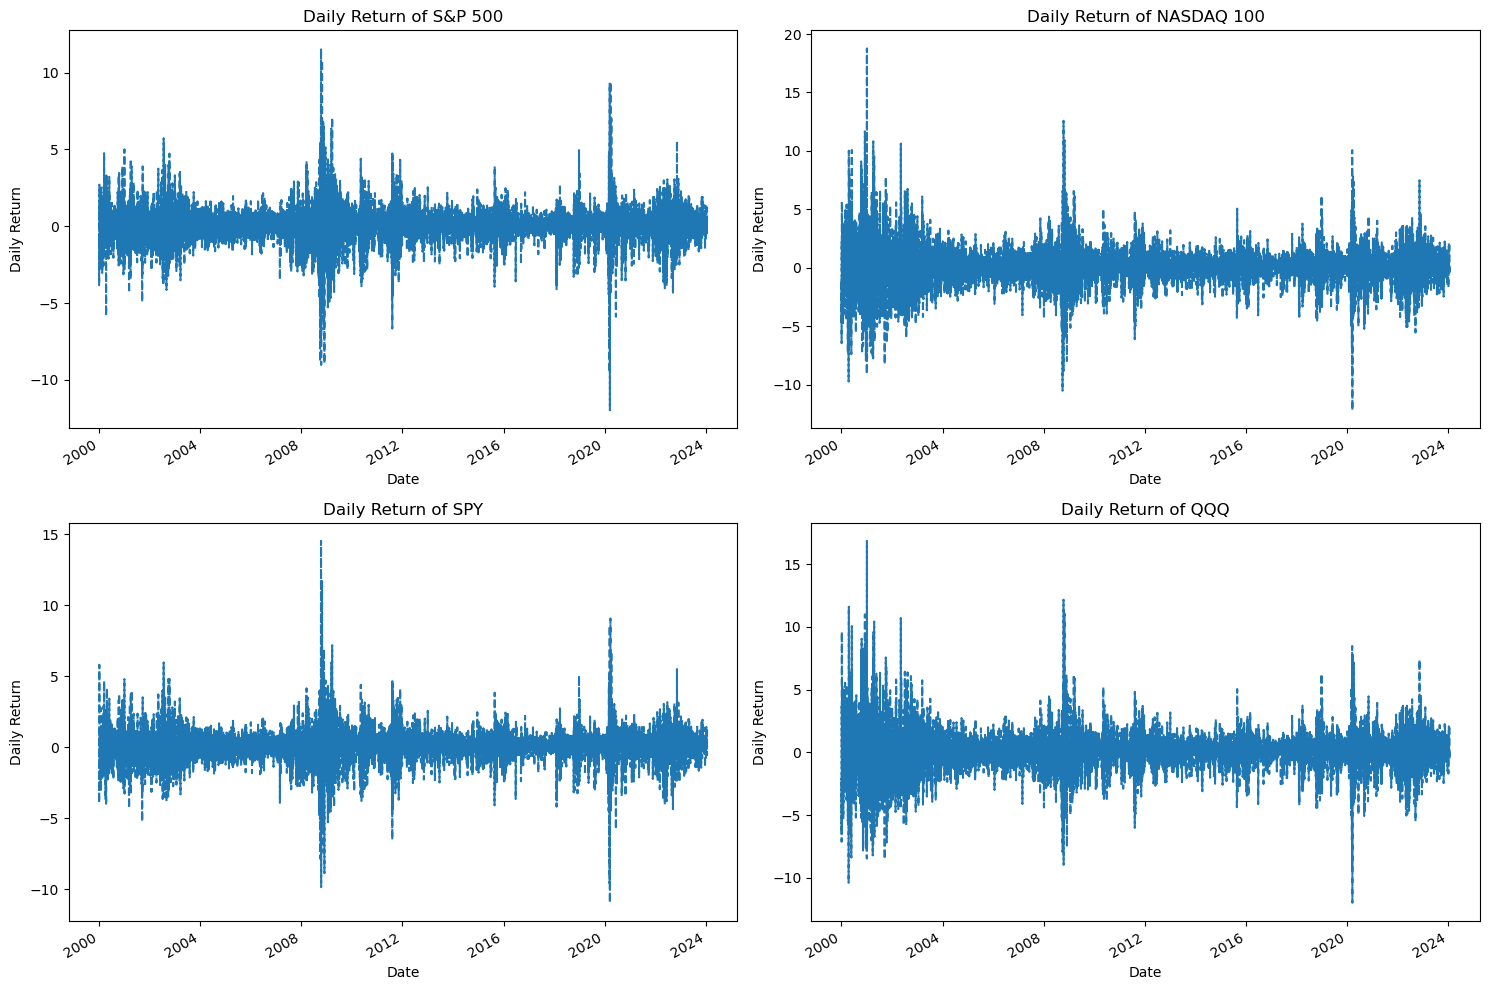

In [109]:
# compare daily returns
plt.figure(figsize=(15, 10))

for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2, 2, i)
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    filtered_df['change_percent'].plot(linestyle='--')   
    plt.ylabel('Daily Return')
    plt.xlabel('Date')
    plt.title(f"Daily Return of {stock_index}")

plt.tight_layout()
plt.show()

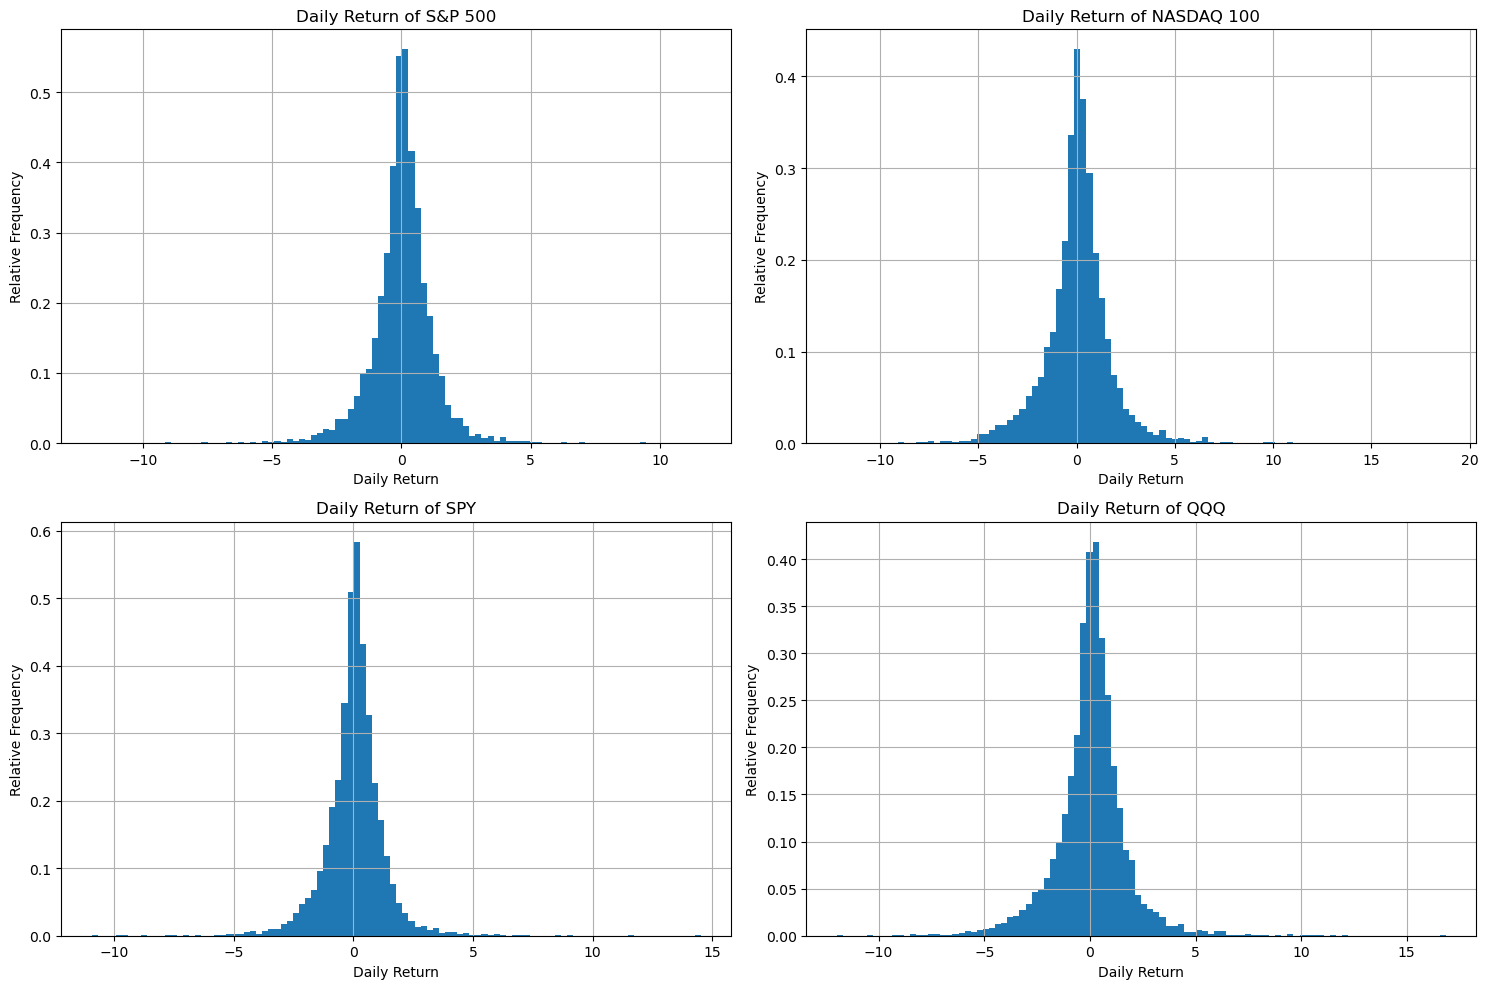

In [114]:
# plot daily return histograms
plt.figure(figsize=(15, 10))

for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2, 2, i)
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    filtered_df['change_percent'].hist(bins=100, density=True)
    plt.ylabel('Relative Frequency')
    plt.xlabel('Daily Return')
    plt.title(f"Daily Return of {stock_index}")

plt.tight_layout()
plt.show()

Finally, to gain a more standardised and comprehensive view of the stock price movements, we visualize each index using **candlestick charts**. We take year 2023 as an example to gain more detailed visualisation. Employing the mpf library, known for its efficacy in financial analysis, we create these charts to depict the high, low, open, close prices and sales volumes for each trading day.

Candlestick charts are a favoured tool among traders and analysts because they provide a wealth of information at a glance. Each 'candle' represents a single day of trading, with the main 'body' showing the opening and closing prices and the 'wicks' indicating the high and low prices of the day. A green body signifies a day where the close was higher than the open, indicating buying pressure, while a red body shows that the stock closed lower than it opened, indicating selling pressure.

This visualisation method is more standardised as it is universally accepted and utilised for its clear representation of price action. It allows us to quickly identify patterns or trends such as bullish or bearish periods, potential market reversals, and moments of indecision in the market.

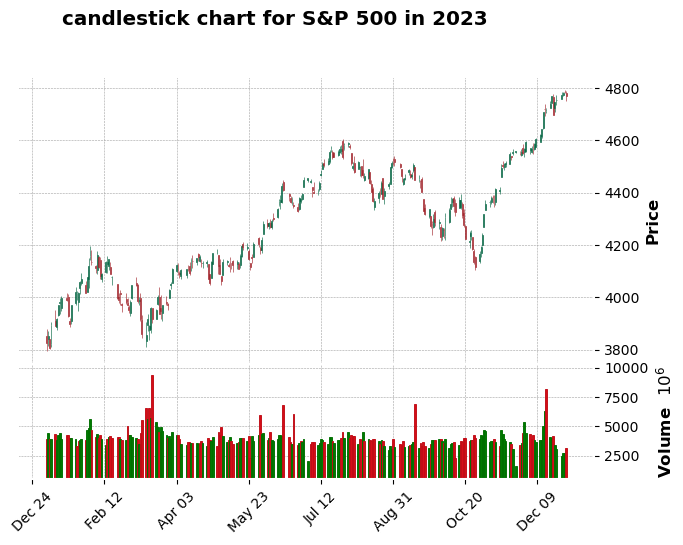

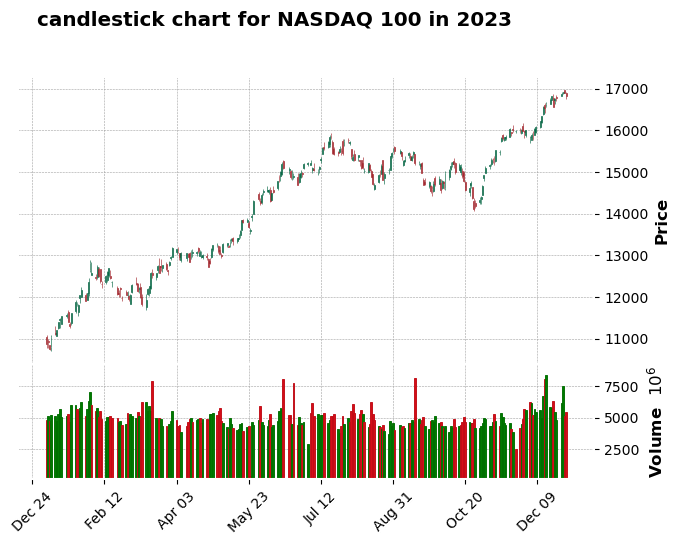

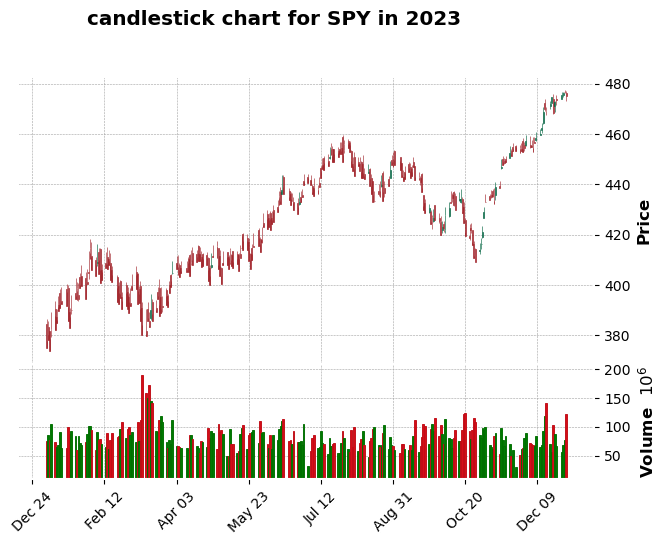

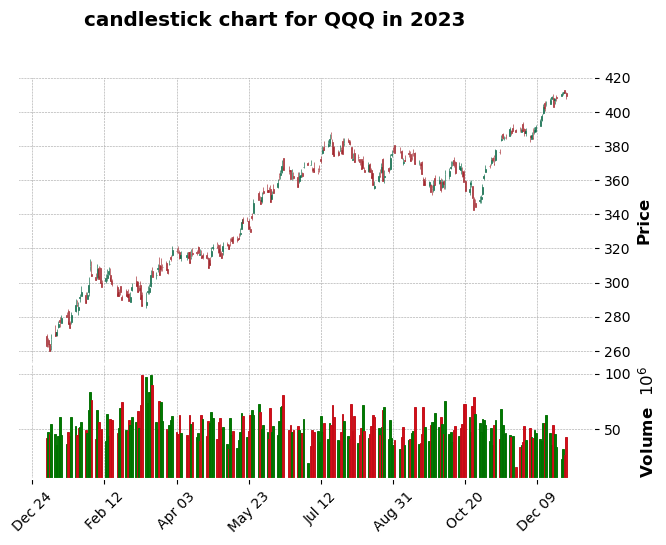

In [117]:
# plot candlestick chart for 2023
for i, stock_index in enumerate(label_list, 1):
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    # filter data for 2023
    df_2023 = filtered_df[filtered_df.index.year == 2023]
    
    # set up kwargs to add title and volume
    kwargs = dict(type='candle', volume=True, title=f"candlestick chart for {stock_index} in 2023", show_nontrading=True)

    mpf.plot(df_2023, **kwargs, style='charles') 

### 5.2 Visualization of Correlations for Stock Market Indexes

Analysing **correlations** between various stock market parameters, such as closing prices and daily returns, through plotting is relevant for several reasons:

* By showing **model validations and robustness**, correlation analysis helps us to replicate real-world market dynamics. By visualizing the correlations between different stock market parameters, particularly closing prices and daily returns, we gain insights into how well our models, such as the Random Forest model, replicate the intricate dynamics of real-world financial markets. This validation is fundamental for ensuring the reliability and accuracy of our predictive tools.

* The exploration of correlations allows us to **differentiate and characterize the distinctive dynamics of each stock market** under scrutiny. High correlations may reveal sectors or markets with strong interdependencies, suggesting potential areas for focused investment strategies. Conversely, lower correlations may indicate more diverse and independent movements, prompting considerations for alternative investment approaches. This nuanced understanding is pivotal for informed decision-making and effective risk management.

* Correlation insights contribute to **informed portfolio construction**. As we aim to compare the Random Forest model's performance across four different stock markets, understanding how stocks within each market move relative to each other is crucial for constructing well-diversified portfolios and managing risk effectively.

In [17]:
# Create a pivot table with closing prices for each stock index
closing_df = combined_df.pivot_table(index=combined_df.index, columns='Stock Index', values='close')
closing_df.head()

Stock Index  NASDAQ 100      QQQ  S&P 500      SPY
date                                              
2000-01-03    3790.5500  81.0423  1455.22  93.8956
2000-01-04    3546.2000  75.2755  1399.42  90.2237
2000-01-05    3507.3101  73.7186  1402.11  90.3851
2000-01-06    3340.8101  69.0677  1403.45  88.9325
2000-01-07    3529.6001  75.6965  1441.47  94.0973

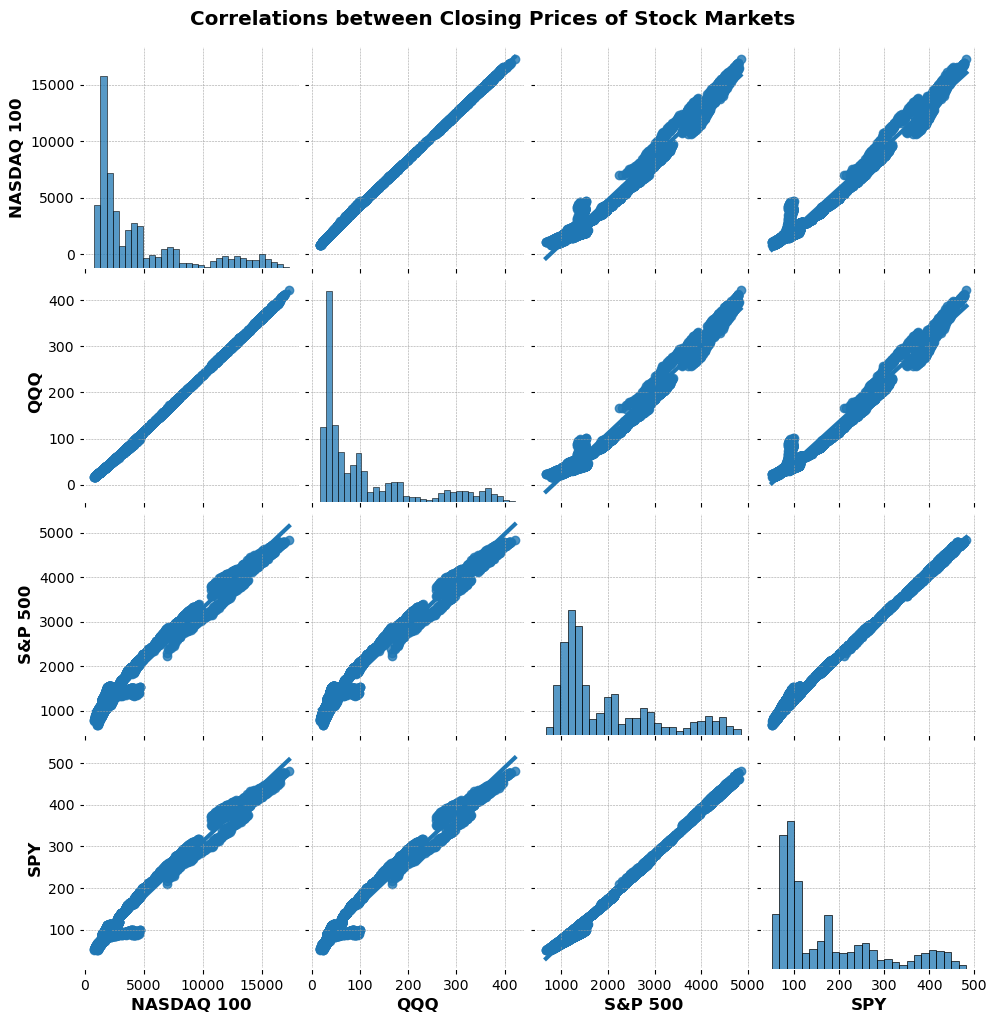

In [119]:
# Creating pair plot for an aoutomated visual analysis of closing prices of all the stock market indexes

sns.pairplot(closing_df, kind='reg').fig.suptitle('Correlations between Closing Prices of Stock Markets', y=1.02);

The substantial positive correlations observed between NASDAQ 100 vs. QQQ and SPY vs. S&P 500 align with the fundamental nature of stock markets. This correlation is not arbitrary but rather reflects the inherent connections within the financial ecosystem.

In the case of NASDAQ 100 and QQQ, the positive correlation can be attributed to the close link between them. QQQ, being an Exchange-Traded Fund (ETF), faithfully tracks the NASDAQ 100 index. Consequently, the movements of QQQ are intricately tied to the collective performance of the companies included in the NASDAQ 100.

Likewise, the positive correlation between SPY and S&P 500 finds its roots in the nature of SPY as an ETF mirroring the movements of the S&P 500 index. The synchronized movements of SPY and the S&P 500 underscore the interdependence between the ETF and the broader market.

The **PairGrid** visualization which is more sophisticated version of pair plot, provides insights into the closing prices of various stock market indexes. Each subplot within the grid serves a specific purpose:

- **Upper Triangular Scatter Plots:** These plots display scatter points, highlighting potential relationships or patterns between pairs of indexes' closing prices.

- **Lower Triangular Kernel Density Plots:** Utilizing a cool color palette, these plots depict the estimated distribution of closing prices, offering insights into the density and variability of the data.

- **Diagonal Histograms:** Histograms showcase the frequency distribution of individual index closing prices, providing a snapshot of their underlying characteristics.

This visualization aims to enhance our understanding of the relationships and distributions within the closing prices dataset, laying the groundwork for further analysis and interpretation.

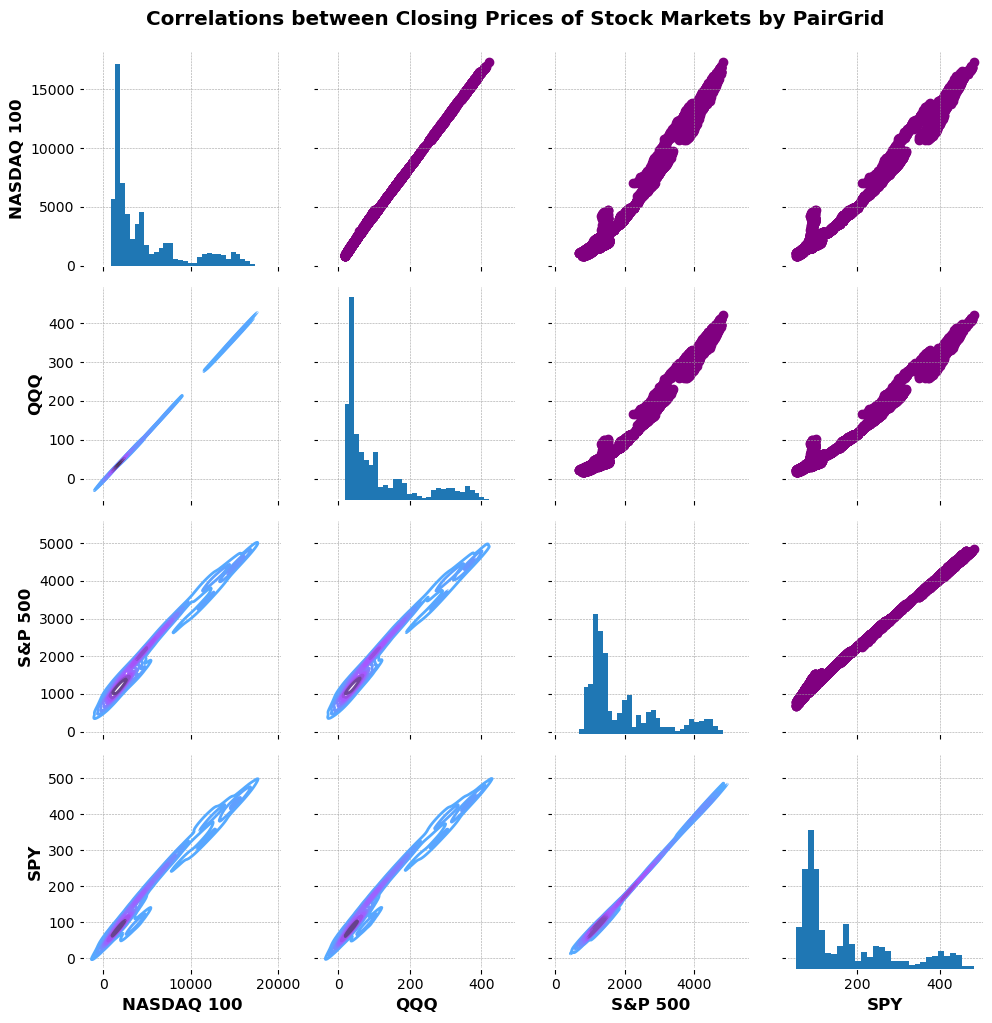

In [120]:
# PairGrid visualisation of the closing prices of the stock market indexes
closing_fig = sns.PairGrid(closing_df.dropna())
closing_fig.map_upper(plt.scatter, color='purple').fig.suptitle('Correlations between Closing Prices of Stock Markets by PairGrid', y=1.02)
closing_fig.map_lower(sns.kdeplot, cmap='cool_d')
closing_fig.map_diag(plt.hist, bins=30);

Now, let's harness from **heatmap**! Plotting heatmap correlations among closing prices of various stock market indexes offers a concise yet powerful visual representation, enabling a quick and comprehensive assessment of the interconnectedness and trends within the stock markets, critical for both model validation and investment decision-making.

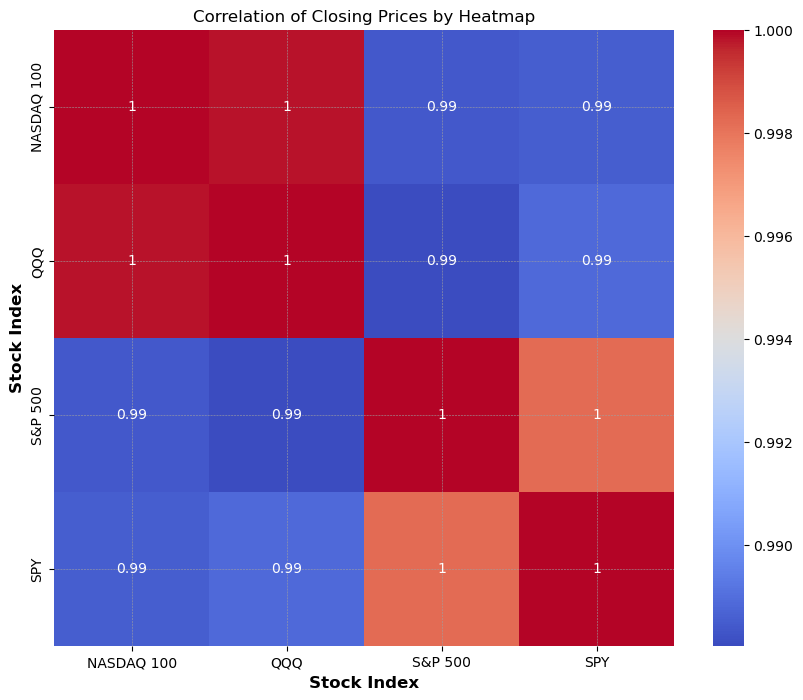

In [20]:
# Heatmap of the correlation between the closing prices of all the stock market indexes
plt.figure(figsize=(10, 8))
sns.heatmap(closing_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of Closing Prices by Heatmap')
plt.show()

The results of the heatmap analysis underscore the intricate relationships and patterns among closing prices of diverse stock market indexes. 

In [21]:
# Create a dataframe with daily returns for each stock index
daily_returns_df = closing_df.pct_change()
daily_returns_df.head()

Stock Index  NASDAQ 100       QQQ   S&P 500       SPY
date                                                 
2000-01-03          NaN       NaN       NaN       NaN
2000-01-04    -0.064463 -0.071158 -0.038345 -0.039106
2000-01-05    -0.010967 -0.020683  0.001922  0.001789
2000-01-06    -0.047472 -0.063090  0.000956 -0.016071
2000-01-07     0.056510  0.095975  0.027090  0.058076

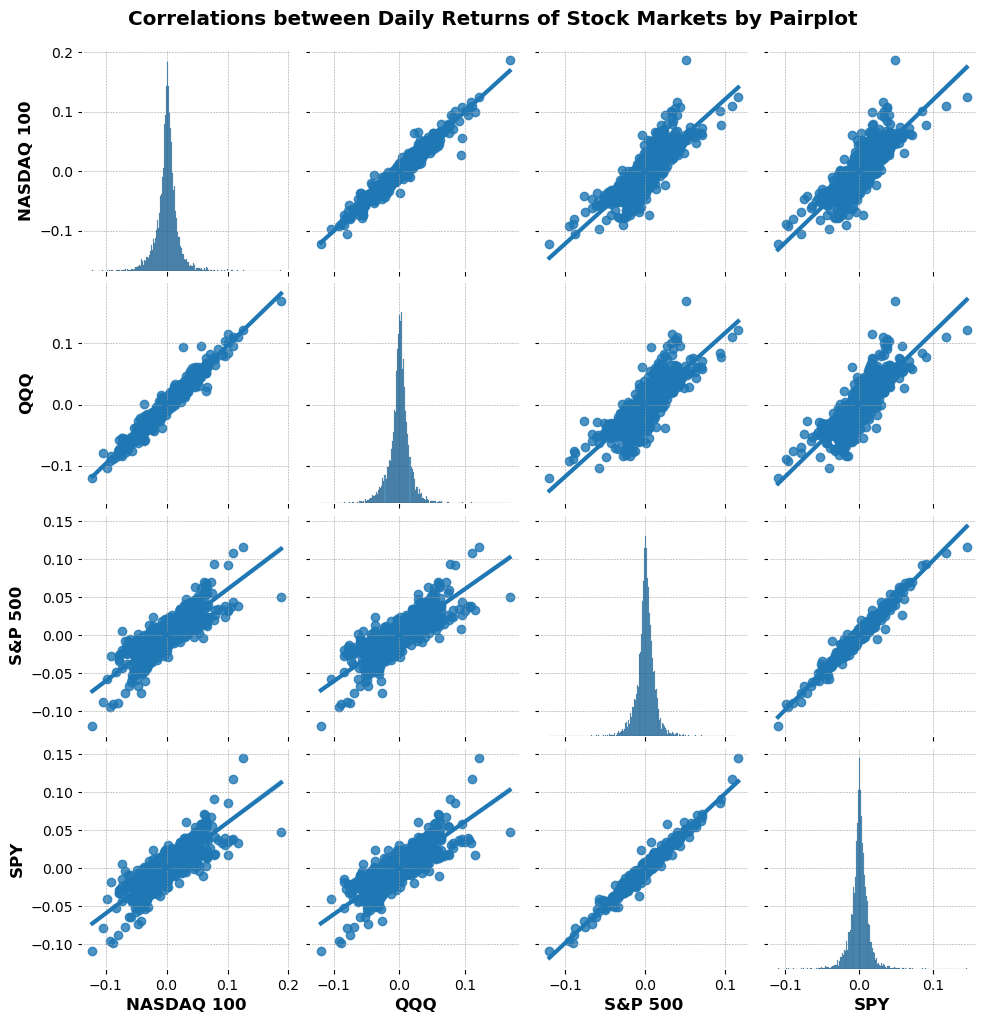

In [121]:
sns.pairplot(daily_returns_df, kind='reg').fig.suptitle('Correlations between Daily Returns of Stock Markets by Pairplot', y=1.02);

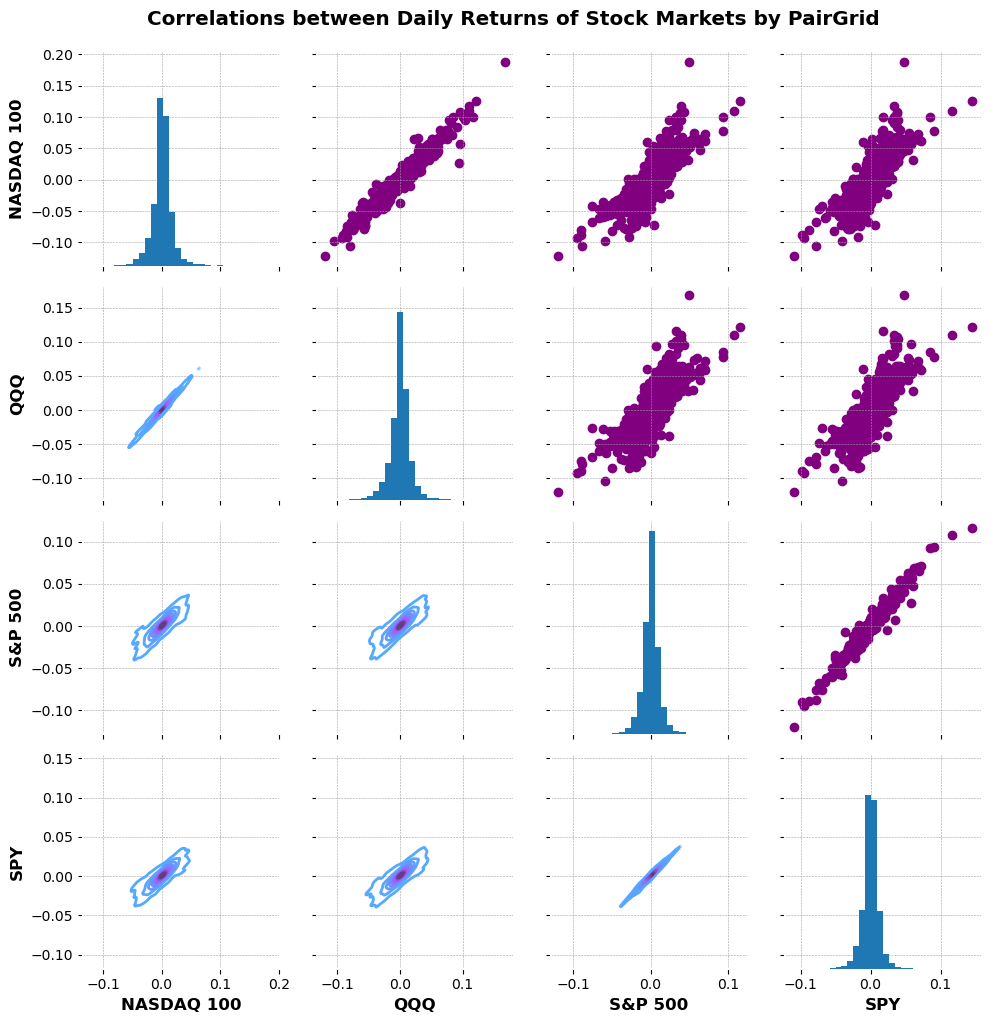

In [122]:
# Pairgrid visualisation of the daily returns of the stock market indexes
returns_fig = sns.PairGrid(daily_returns_df.dropna())
returns_fig.map_upper(plt.scatter, color='purple').fig.suptitle('Correlations between Daily Returns of Stock Markets by PairGrid', y=1.02)  
returns_fig.map_lower(sns.kdeplot, cmap='cool_d')
returns_fig.map_diag(plt.hist, bins=30);

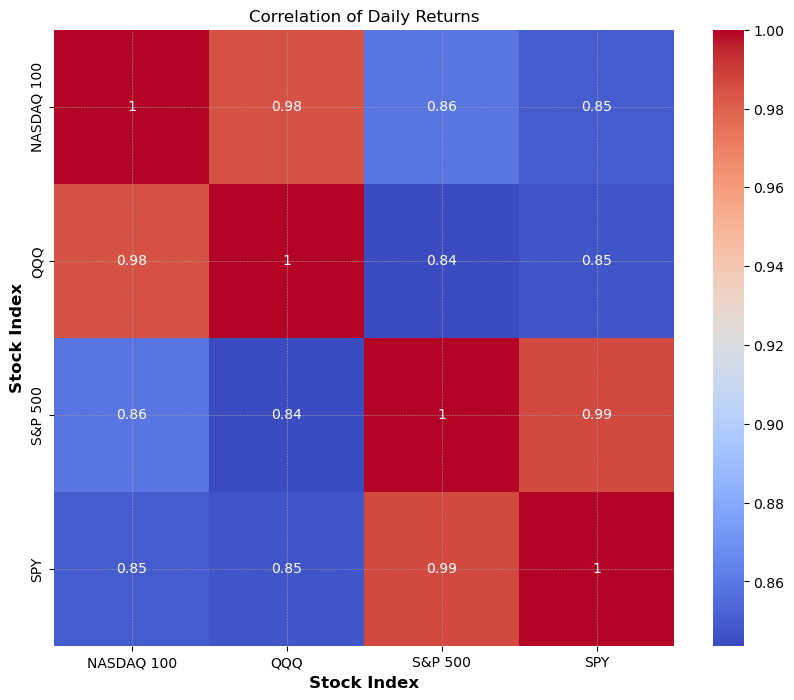

In [24]:
# Heatmap for the daily returns of the stock market indexes
plt.figure(figsize=(10, 8))
returns_df = combined_df.pivot_table(index='date', columns='Stock Index', values='change_percent')
sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of Daily Returns')
plt.show()

Overall, the persistence of positive correlations in both closing prices and daily returns underscores the stability of the relationships between NASDAQ 100 and QQQ, as well as SPY and the S&P 500. Whether analyzing closing prices or daily returns, investors and analysts can have confidence in the reliability of these instruments to capture the respective movements of their underlying benchmarks.

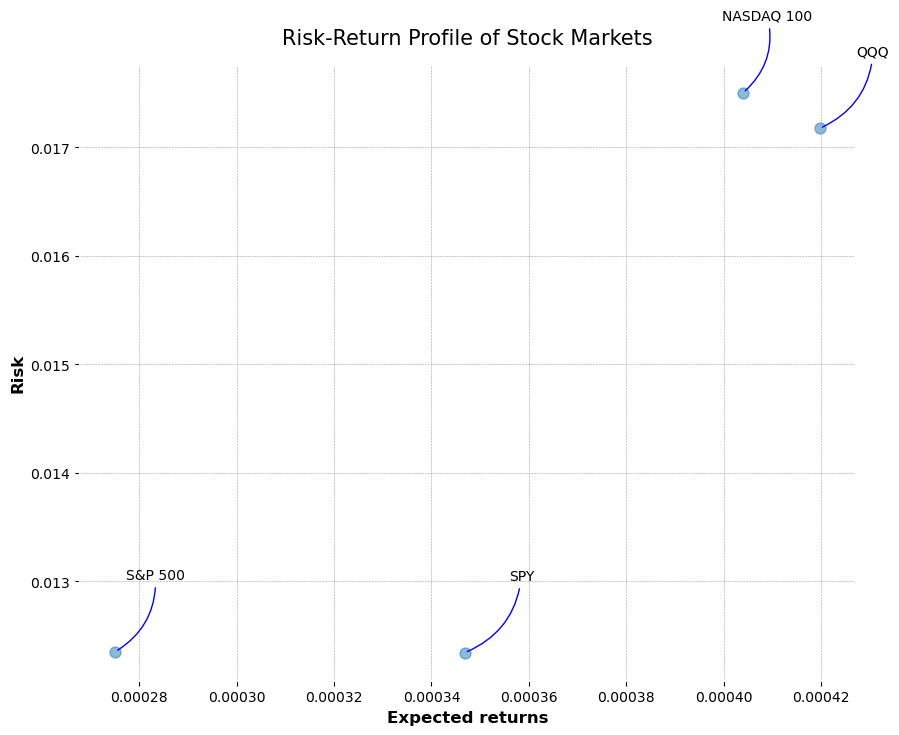

In [25]:
# Quantify the risk of an individual stock by comparing the expected return (which can be the mean of the daily returns) with the standard deviation of the daily returns

rets = daily_returns_df.dropna()
area = np.pi*20
plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), alpha=0.5, s=area)
plt.xlabel('Expected returns')
plt.ylabel('Risk')
# Annotate each point with the corresponding stock label
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
plt.title("Risk-Return Profile of Stock Markets", y=1.02, fontsize=15)
plt.show()

This visualization helps you visually assess the **risk-return profile** of each stock. NASDAQ 100 and QQQ, which are located in the upper-left corner of the plot, respresent stocks with higher expected returns and lower risk which makesmthem potentially more attractive to investors seeking a favorable risk-return tradeoff. Also, invests in the QQQ can benefit from the full gains of the NASDAQ 100 when it rises as an adavantage of passive investing.

On the contrary, the position in the left-bottom corner indicates that, on average, the S&P 500 have lower expected returns (mean of daily returns) compared to other stocks in the dataset. It also suggests that both the S&P 500 and SPY have lower risk compared to other stocks. They might be considered less volatile or less risky investments.

Furthermore, SPY and QQQ are expected to have higher average returns compared to the broader indices S&P 500 and NASDAQ 100. The tracking ETFs SPY and QQQ may be actively managed or structured in a way that allows them to capture more of the market's upsides, leading to higher expected returns.

## 6. Next Day Close Price Prediction

Economy researchers have paid attention to stock price predictions for decades. None of the prediction models can reach 100% accuracy. What researchers are constantly working on is improving the performance of prediction models. Nowadays, machine learning gains popularity in prediction modelling. Different data sets, research questions, and central points may suit different machine learning methods. Prediction can usually be categorised into two types: directional prediction (classification problem) and accurate numerical prediction (regression problem). Since slight changes in the stock price are significant, this research aims to conduct an accurate numeric prediction.

Machine learning includes ensemble learning, which is made up of many weakly supervised learning models. While each model only focuses on a specific area, combining them together can improve overall model performance. To alleviate the overfitting problem, bagging was designed (Breiman, 1996), and tree-based algorithms were further developed that can rank variables by importance (Kern et al., 2019), so it is unnecessary to verify the importance and validity of every explanatory variable before using them.

The random forests algorithm is tree-based and suitable for researching nonlinear problems. Economic theory also supports that the relationship between economic indicators is more likely to be nonlinear, which means that changes in one variable do not result in a proportional change in the other variable. This study chooses random forests to build prediction models.

Random forests combine many decision trees together (Breiman, 2001). Random means random generation of the same size of samples from training data. In this process, each individual tree may be trained with two-thirds of the initial dataset, while the rest never used in training is called out-of-bag (OOB) (Breiman, 2001). Random forests employed in regression problems will calculate the average of the output of each tree in the forest as a final output. The process of averaging can reduce variance in order to perform better than a single decision tree and other logistic regression models (Kern et al., 2019). 

We split the data from 2000-2021 (inclusive) as training data and the data after 2022 (inclusive) as test data.

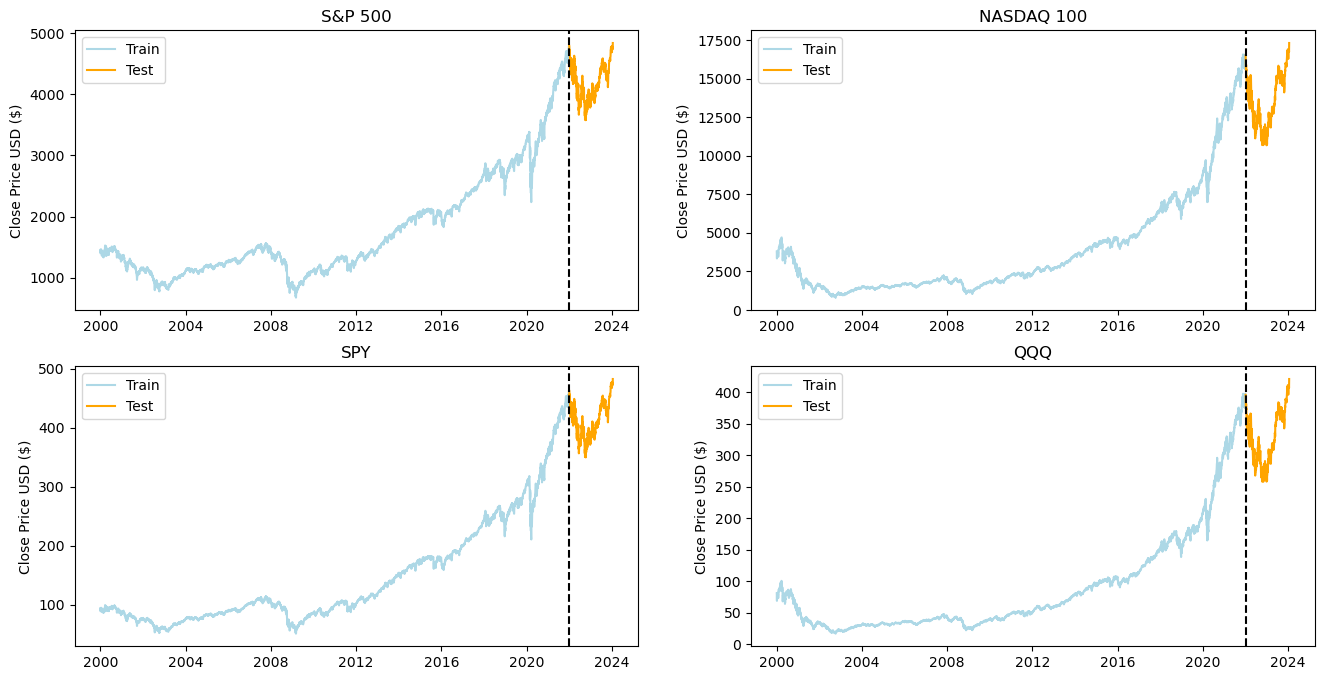

In [124]:
def sample_split_visu(data):
    train = data.loc['2000-01-01':'2021-12-31']
    test = data.loc['2022-01-01':]
    plt.plot(train['close'], label='Train', color='lightblue')
    plt.plot(test['close'], label='Test', color='orange')
    plt.ylabel('Close Price USD ($)')
    plt.axvline(x=datetime.datetime(2022,1,1), color='black', linestyle='--')
    plt.legend(loc='upper left')

plt.figure(figsize=(16,8))
for i, stock_index in enumerate(label_list, 1):
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    plt.subplot(2,2,i)
    sample_split_visu(filtered_df)
    plt.title(stock_index)
plt.style.use('default')
plt.show()

### 6.1 Test Parameters

We build the prediction model with the help of **sklearn.ensemble.RandomForestRegressor**. Seven parameters may have a significant impact on the model performance.

- **"n_estimators"** means the number of trees in the forest. The default number is 100.
- **"max_depth"** means the maximum depth of each tree. Without setting this parameter, nodes will be expanded until all leaves are pure.
- **"min_samples_split"** means The minimum number of samples required to split an internal node. The default number is 2.
- **"min_samples_leaf"** means The minimum number of samples required to be at a leaf node. The default number is 1.
- **"min_weight_fraction_leaf"** means the minimum weighted fraction of the total weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
- **"max_features"** means the number of features to consider. Without setting this parameter, all features will be considered.
- **"max_leaf_nodesint"** means to grow trees with max_leaf_nodes in the best-first fashion. Without setting this parameter, trees will grow with an unlimited number of leaf nodes.

We set 10 explanatory variables (features): open price, highest price, close price, lowest price, volume, change per cent, 20 days average volume, 5 days average price, 10 days average price, 20 days average price. Our sample size is not large, with no missing variables and not a large number of features, so for better model performance and lower computational consumption, we choose to test these two parameters **("n_estimators", and "max_depth" )** to find the most optimal model. 

R-squared, suggested as a standard metric in regression model evaluation (Chicco et al., 2021), is the proportion of the variance predicted by the model. Hence, it can measure the degree of success in predicting the response variable from the explanatory variables. We evaluate the model performance with the R2 score. The closer to 1, the better.

We tested 30, 50, 100, 500, and 1000 trees in the forest and found that such a high number of trees did not lead to significant improvement, so we locked the number of trees between 30-120 (exclusive) and tested again.

We tested 3, 7, 10, 15, and 20 depths of each tree and found that such a depth of tree did not lead to significant improvement, so we locked the maximum depth between 4-13 (exclusive) and tested again.

In [27]:
def rf_model_test(data,n_estimators,max_depth):
    data_train = data.loc['2000-01-01':'2021-12-31']
    data_test = data.loc['2022-01-01':]
    x_train = data_train[['open','high','close','low','volume','change_percent','avg_vol_20d','avg_pri_5d','avg_pri_10d','avg_pri_20d']]
    y_train = data_train['close_nextday']
    x_test = data_test[['open','high','close','low','volume','change_percent','avg_vol_20d','avg_pri_5d','avg_pri_10d','avg_pri_20d']]
    y_test = data_test['close_nextday']
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,oob_score=True)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    return metrics.r2_score(y_test, y_pred)

In [28]:
def get_performance(data):
    preformance = pd.DataFrame(columns=['n_estimators','max_depth','R2'])
    for i in range(30,120,10):
        for j in range(4,13,1):
            R2 = rf_model_test(data,n_estimators=i,max_depth=j)
            preformance = preformance.append({'n_estimators':i,'max_depth':j,'R2':R2},ignore_index=True)
    return preformance

Each parameter test code will run for over a minute and 50 seconds. We don't use GridSearchCV because it runs too slow.

In [29]:
SP500_performance = get_performance(combined_df[combined_df['Stock Index'] == 'S&P 500'])

In [30]:
ND100_performance = get_performance(combined_df[combined_df['Stock Index'] == 'NASDAQ 100'])

In [31]:
QQQ_performance = get_performance(combined_df[combined_df['Stock Index'] == 'QQQ'])

In [32]:
SPY_performance = get_performance(combined_df[combined_df['Stock Index'] == 'SPY'])

The random forest method will randomly generate the same size of samples from training data, which means running the above code again may see a different result.

In [33]:
def para_test_visu(performance):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(projection='3d')
    X = performance['n_estimators']
    Y = performance['max_depth']
    Z = performance['R2']
    surf = ax.plot_trisurf(X, Y, Z, antialiased=True, cmap='coolwarm', alpha=0.5)
    ax.set_zlim(0.8, 1)
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('max_depth')
    ax.set_zlabel('R2')
    fig.colorbar(surf, shrink=0.5, aspect=8)
    max_point = performance[performance['R2']==performance['R2'].max()].values.tolist()[0]
    x = (max_point[0],max_point[0])
    y = (max_point[1],max_point[1])
    z = (0.8,max_point[2])
    ax.plot(x, y, z,'g--')
    x = (max_point[0],max_point[0])
    y = (5,max_point[1])
    z = (max_point[2],max_point[2])
    ax.plot(x, y, z,'g--')
    x = (30,max_point[0])
    y = (max_point[1],max_point[1])
    z = (max_point[2],max_point[2])
    ax.plot(x, y, z,'g--')
    ax.scatter(max_point[0],max_point[1],max_point[2], color='green')
    return 'reach highest ${R^2}$ score when'+'\n'+'n_estimators='+str(int(max_point[0]))+'; max_depth='+str(int(max_point[1])),int(max_point[0]),int(max_point[1])

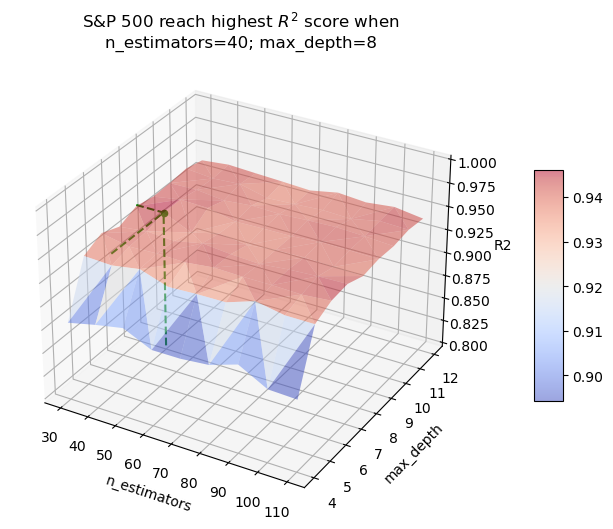

In [127]:
best_para = {}    
t,n,m = para_test_visu(SP500_performance)
best_para['S&P 500'] = [n,m]
plt.title('S&P 500 '+ t);

From the above plot, we can see the green dot is the point that reaches the relative highest performance. We will use the corresponding optimal parameters to build Standard and Poor's 500 next-day close price prediction model.

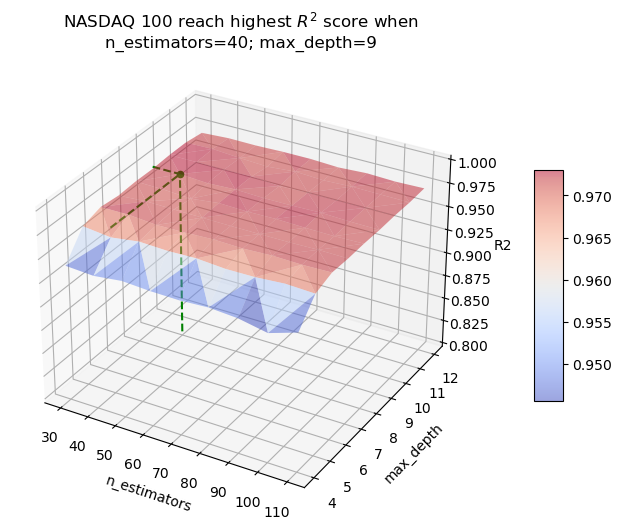

In [130]:
t,n,m = para_test_visu(ND100_performance)
best_para['NASDAQ 100'] = [n,m]
plt.title('NASDAQ 100 '+ t);

From the above plot, we can see the green dot is the point that reaches the relative highest performance. We will use the corresponding optimal parameters to build NASDAQ 100 next-day close price prediction model.

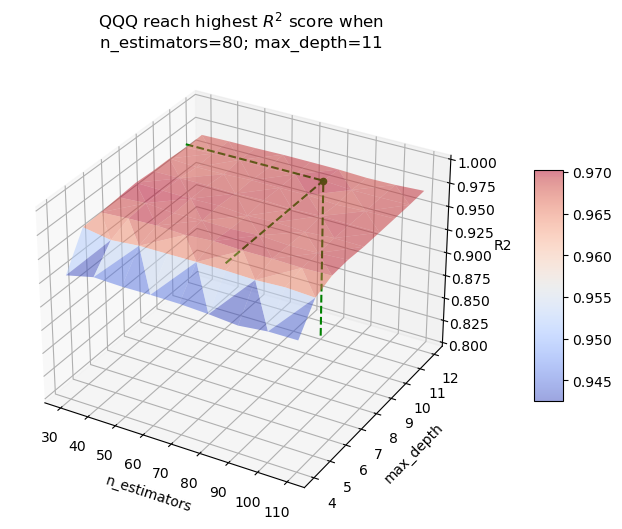

In [131]:
t,n,m = para_test_visu(QQQ_performance)
best_para['QQQ'] = [n,m]
plt.title('QQQ '+ t);

From the above plot, we can see the green dot is the point that reaches the relative highest performance. We will use the corresponding optimal parameters to build Invesco QQQ Trust next-day close price prediction model.

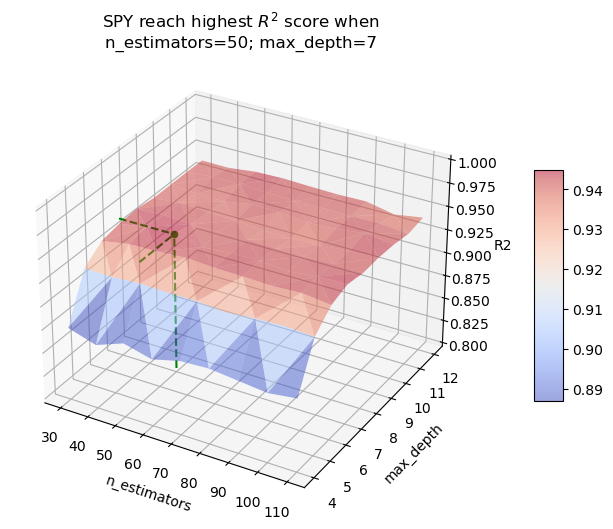

In [132]:
t,n,m = para_test_visu(SPY_performance)
best_para['SPY'] = [n,m]
plt.title('SPY '+ t);

From the above plot, we can see the green dot is the point that reaches the relative highest performance. We will use the corresponding optimal parameters to build SPDR S&P 500 ETF Trust (SPY) next-day close price prediction model.

### 6.2 Build and Evaluate Models

According to the above part of the parameter test, we will build models with the following parameters.

In [135]:
for i in best_para:
    print('The '+ i +' prediction model: '+'n_estimators='+str(best_para[i][0])+'; max_depth='+str(best_para[i][1]))

The S&P 500 prediction model: n_estimators=40; max_depth=8
The NASDAQ 100 prediction model: n_estimators=40; max_depth=9
The QQQ prediction model: n_estimators=80; max_depth=11
The SPY prediction model: n_estimators=50; max_depth=7


In [38]:
def rf_model(data,n_estimators,max_depth):
    data_train = data.loc['2000-01-01':'2021-12-31']
    data_test = data.loc['2022-01-01':]
    x_train = data_train[['open','high','close','low','volume','change_percent','avg_vol_20d','avg_pri_5d','avg_pri_10d','avg_pri_20d']]
    y_train = data_train['close_nextday']
    x_test = data_test[['open','high','close','low','volume','change_percent','avg_vol_20d','avg_pri_5d','avg_pri_10d','avg_pri_20d']]
    y_test = data_test['close_nextday']
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,oob_score=True)
    rf.fit(x_train, y_train)
    y_test_pred = rf.predict(x_test)
    y_train_pred = rf.predict(x_train)
    MAE = metrics.mean_absolute_error(y_test, y_test_pred)
    MSE = metrics.mean_squared_error(y_test, y_test_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    R2 = metrics.r2_score(y_test, y_test_pred)
    evaluate = (MAE, MSE, RMSE, R2, rf.oob_score_)
    return y_test_pred, y_train_pred, evaluate, rf.feature_importances_

In [39]:
test_pred = pd.DataFrame(columns=label_list)
test_pred['date'] = combined_df[combined_df['Stock Index'] == 'S&P 500'].loc['2022-01-01':].index
train_pred = pd.DataFrame(columns=label_list)
train_pred['date'] = combined_df[combined_df['Stock Index'] == 'S&P 500'].loc['2000-01-01':'2021-12-31'].index
pred_evaluate = pd.DataFrame(columns=label_list)
vimp = pd.DataFrame(columns=label_list)
test_pred['S&P 500'],train_pred['S&P 500'],pred_evaluate['S&P 500'],vimp['S&P 500'] = rf_model(SP500,best_para['S&P 500'][0],best_para['S&P 500'][1])
test_pred['NASDAQ 100'],train_pred['NASDAQ 100'],pred_evaluate['NASDAQ 100'],vimp['NASDAQ 100'] = rf_model(ND100,best_para['NASDAQ 100'][0],best_para['NASDAQ 100'][1])
test_pred['QQQ'],train_pred['QQQ'],pred_evaluate['QQQ'],vimp['QQQ'] = rf_model(QQQ,best_para['QQQ'][0],best_para['QQQ'][1])
test_pred['SPY'],train_pred['SPY'],pred_evaluate['SPY'],vimp['SPY'] = rf_model(SPY,best_para['SPY'][0],best_para['SPY'][1])
pred_evaluate.index = ['MAE','MSE','RMSE','R2','oob_score']
vimp.index = ['open','high','close','low','volume','change_percent','avg_vol_20d','avg_pri_5d','avg_pri_10d','avg_pri_20d']
test_pred = test_pred.set_index('date')
train_pred = train_pred.set_index('date')

Now we plot the true value and the prediction value on the test set. 

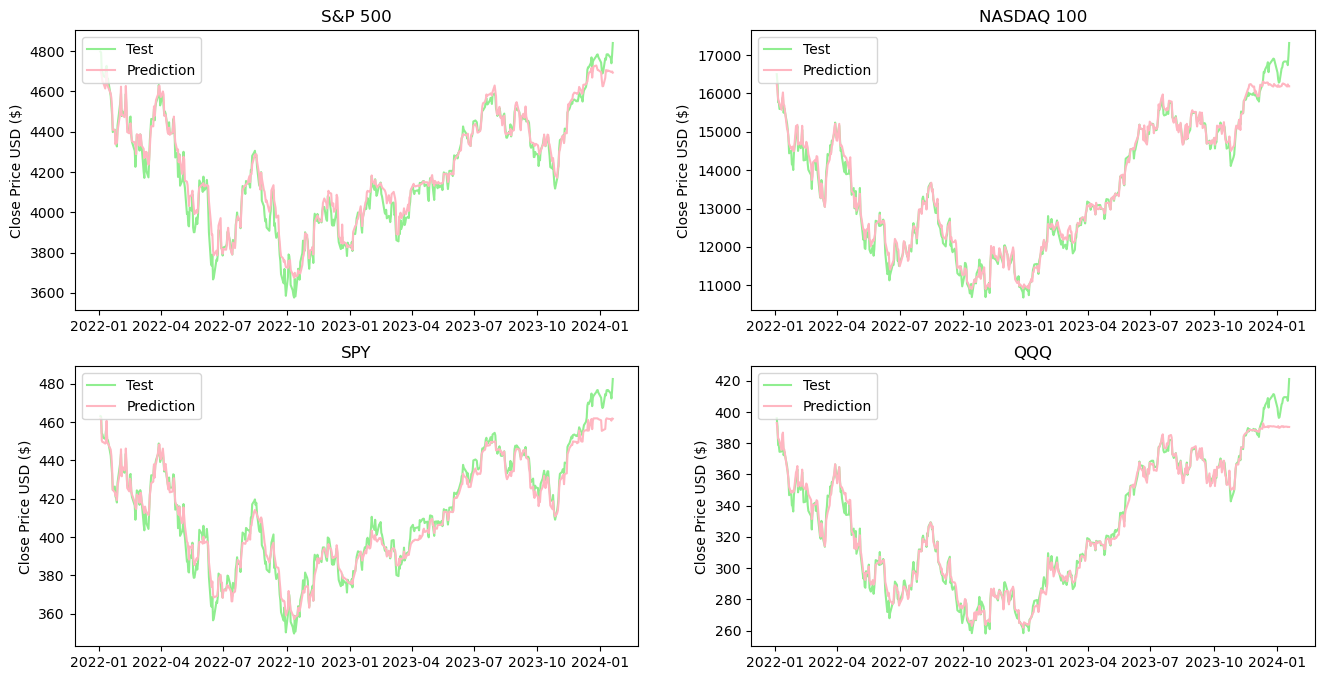

In [136]:
plt.figure(figsize=(16,8))
for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2,2,i)
    plt.plot(combined_df[combined_df['Stock Index'] == stock_index].loc['2022-01-01':]['close'], label='Test', color='lightgreen')
    plt.plot(combined_df[combined_df['Stock Index'] == stock_index].loc['2022-01-01':].index, test_pred[stock_index], label='Prediction', color='lightpink')
    plt.ylabel('Close Price USD ($)')
    plt.legend(loc='upper left')
    plt.title(stock_index)
plt.show()

As seen from the above plot, our prediction model performs well and the difference between the prediction value and the true value is small. We can also use a scatter plot to visualize the predictions against the true values.

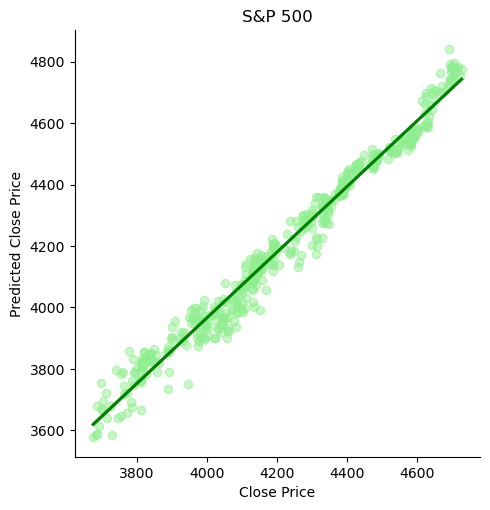

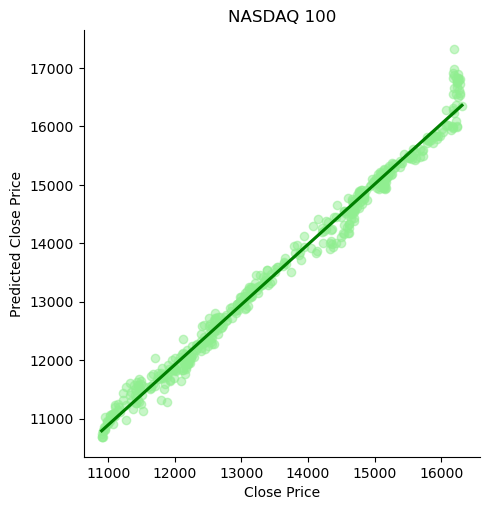

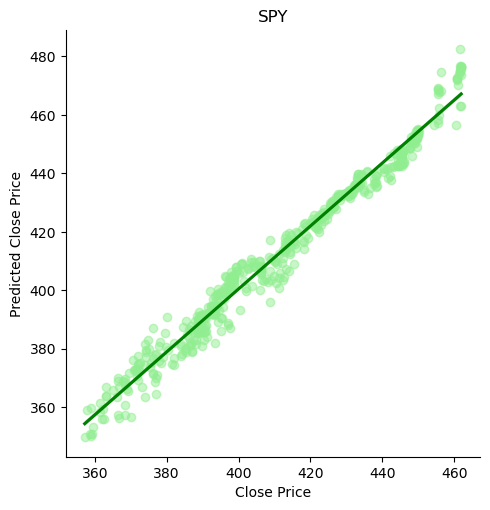

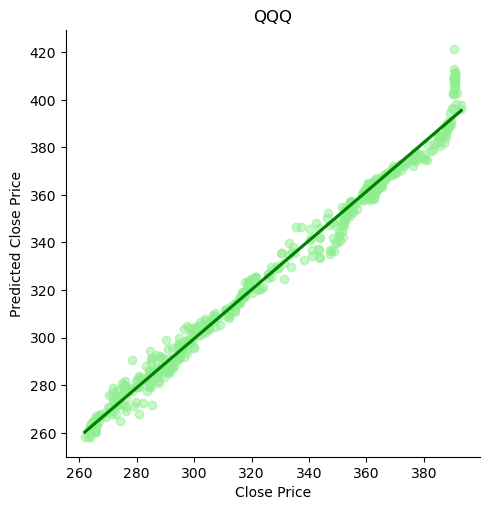

In [137]:
for stock_index in label_list:
    sns.lmplot(x=stock_index, y='close', data=pd.concat([test_pred[stock_index],combined_df[combined_df['Stock Index'] == stock_index].loc['2022-01-01':]['close']],axis=1), scatter_kws={'alpha':0.5,'color':'lightgreen'}, line_kws={'color':'green'})
    plt.xlabel('Close Price')
    plt.ylabel('Predicted Close Price')
    plt.title(stock_index)
plt.show()

From the above plot, it can be noticed that all the scatter points are distributed around the baseline, indicating that the gap between the prediction and the true value is small and models are performing well.

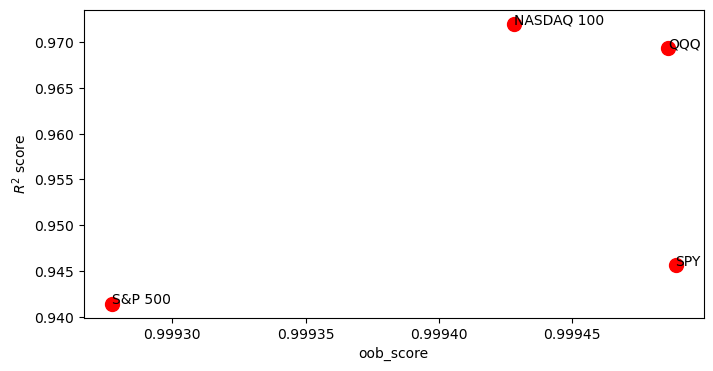

In [138]:
plt.figure(figsize=(8,4))
plt.scatter(pred_evaluate.loc['oob_score'],pred_evaluate.loc['R2'],color='red',s=100)
for stock_index in label_list:
    plt.annotate(stock_index, xy=(pred_evaluate.loc['oob_score'][stock_index],pred_evaluate.loc['R2'][stock_index]))
plt.xlabel('oob_score')
plt.ylabel('${R^2}$ score')
plt.show()

The OOB set can be used to estimate the model performance on unseen data, and test the generation ability of the model. The OOB score in regression models is the proportion of the variance forecasted by the model in the OOB samples (N. J. D. Nagelkerke, 1991). As seen in the above plot, each model has a very high $R^2$ score and OOB score, indicating that the model predictions perform well. The NASDAQ 100 model has the highest $R^2$ score and SPY model has the highest OOB score.

### 6.3 Error Analysis
Error analysis is a crucial step in model evaluation. We plot the error distribution on both the training and the test set.

In [43]:
for stock_index in label_list:
    test_pred[stock_index+'_test_error'] = test_pred[stock_index]-combined_df[combined_df['Stock Index'] == stock_index].loc['2022-01-01':]['close']
    train_pred[stock_index+'_train_error'] = train_pred[stock_index]-combined_df[combined_df['Stock Index'] == stock_index].loc['2000-01-01':'2021-12-31']['close']

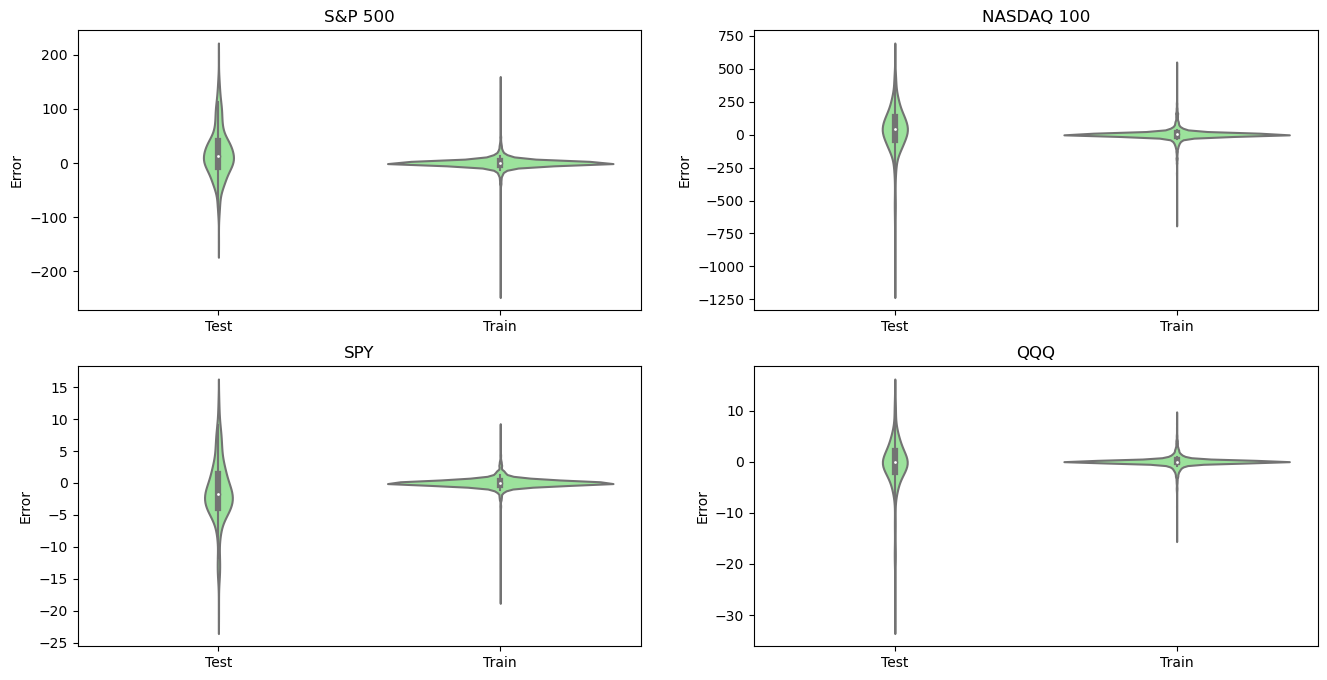

In [139]:
plt.figure(figsize=(16,8))
for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2,2,i)
    sns.violinplot(data=(test_pred[stock_index+'_test_error'],train_pred[stock_index+'_train_error']), color='lightgreen')
    plt.xticks([0,1],['Test','Train'])
    plt.ylabel('Error')
    plt.title(stock_index)
plt.show()

As seen in the plot above, the error distributions of the four models perform similarly. The errors in the training set are more centrally distributed than in the test set. There are individual data points with bigger errors. The prediction error for SP500 is mainly distributed at ±100. The prediction error for NASDQAQ 100 is mainly distributed at ±250. The prediction error for QQQ and SPY is mainly distributed at ±10. These differences are due to the characteristics of these stock indexes themselves. 

We then use the base 10 logarithm number to compare errors. There are 3 main ways to evaluate errors for regression models: 
- Mean Absolute Error **(MAE)** is calculated as the sum of absolute errors divided by the sample size.
- Mean Squared Error **(MSE)** is the average squared difference between the estimated values and the actual value.
- Root Mean Square Error **(RMSE)** is the square root of MSE.

In [45]:
pred_evaluate

S&P 500    NASDAQ 100        SPY        QQQ
MAE          52.534113    212.498933   5.586632   5.318324
MSE        4889.465726  78778.303517  48.597232  52.048439
RMSE         69.924715    280.674729   6.971171   7.214460
R2            0.941448      0.972025   0.945627   0.969378
oob_score     0.999277      0.999428   0.999489   0.999486

In [46]:
pred_evaluate_log = pred_evaluate.copy()
for i in pred_evaluate.columns:
    pred_evaluate_log[i][:3] = np.log10(pred_evaluate[i][:3])
pred_evaluate_log

S&P 500  NASDAQ 100       SPY       QQQ
MAE        1.720441    2.327357  0.747150  0.725775
MSE        3.689261    4.896407  1.686612  1.716408
RMSE       1.844631    2.448203  0.843306  0.858204
R2         0.941448    0.972025  0.945627  0.969378
oob_score  0.999277    0.999428  0.999489  0.999486

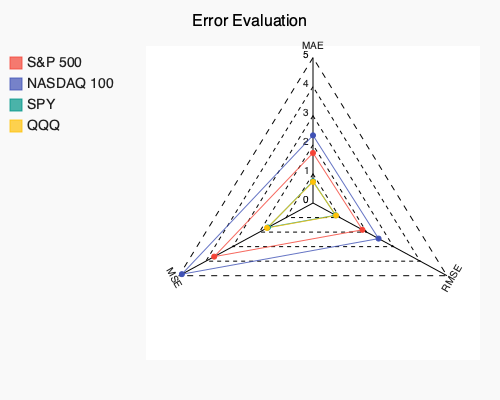

In [140]:
radar = pygal.Radar(range=(0,5),height=400,width=500)
radar.x_labels = ['MAE','MSE','RMSE']
radar.title = 'Error Evaluation'
for stock_index in label_list:
    radar.add(stock_index, pred_evaluate_log[stock_index][:3])
radar

The prediction error of the NASDAQ 100 is relatively higher, and the S&P 500 is the second highest. The error characteristics of the QQQ model and SPY model are similar (almost overlap). We then plot the relative frequency of error distribution.

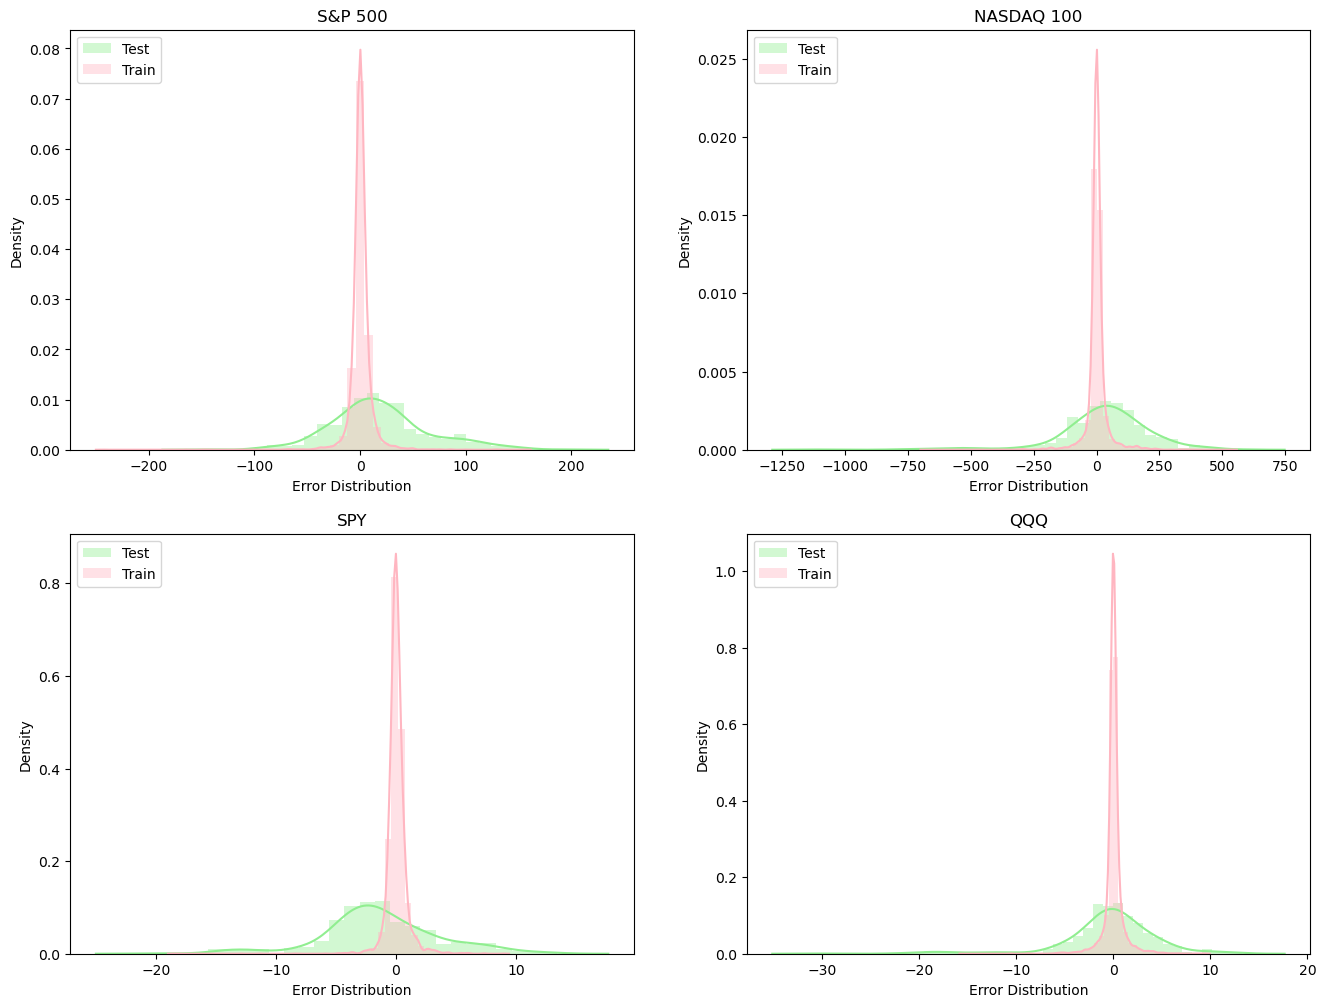

In [141]:
plt.figure(figsize=(16,12))
for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2,2,i)
    sns.distplot(test_pred[stock_index+'_test_error'], color='lightgreen', label='Test')
    sns.distplot(train_pred[stock_index+'_train_error'], color='lightpink', label='Train')
    plt.xlabel('Error Distribution')
    plt.legend(loc='upper left')
    plt.title(stock_index)
plt.show()

We can see some different information from the violin plot. For the S&P 500 and NASDAQ 100 test data, errors occur relatively more frequently due to the higher prediction. However, for the SPY test data, errors occur relatively more frequently due to the lower prediction.

### 6.4 Variable Importance Measure ###

Random forests have an advantage in calculating the variable importance, which is calculated using the decrease of the OOB score when a single feature is excluded from the model. This process can break the connection between features and detect how much the model depends on a specific feature. Then the relative importance of every explanatory variable is figured out.

<Axes: >

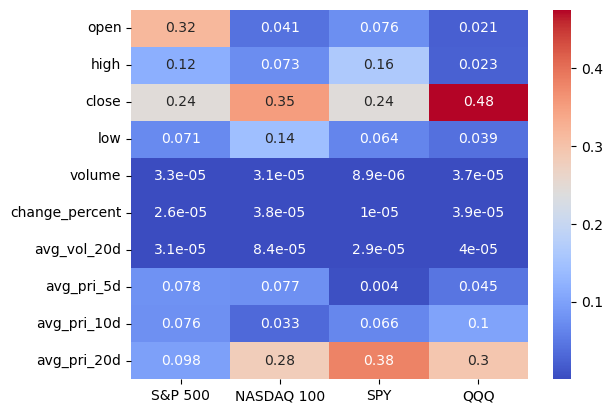

In [142]:
sns.heatmap(vimp, annot=True, cmap='coolwarm')

The redder the colour the more important the explanatory variable is. From the above plot, the top 2 most important explanatory variables in the stock next-day close price prediction model are 20 days average price and close price today. The volume, 20 days average volume, and change percentage are the most unimportant explanatory variables. 

The top 3 most important explanatory variables in each model are:

In [157]:
explain = {'open':'opening price today', 'high':'highest price today', 'close':'closing price today', 'low':'lowest price today', 'volume':'volume today', 'change_percent':'daily change percent', 'avg_vol_20d':'average volume of the past 20 days', 'avg_pri_5d':'average closing price of the past 5 days', 'avg_pri_10d':'average closing price of the past 10 days', 'avg_pri_20d':'average closing price of the past 20 days'}
for stock_index in label_list:
    n = list(vimp[stock_index].sort_values(ascending=False)[:3].index)
    print(stock_index+': '+ explain[n[0]]+'; '+explain[n[1]]+'; '+explain[n[2]])

S&P 500: opening price today; closing price today; highest price today
NASDAQ 100: closing price today; average closing price of the past 20 days; lowest price today
SPY: average closing price of the past 20 days; closing price today; highest price today
QQQ: closing price today; average closing price of the past 20 days; average closing price of the past 10 days


### 6.5 Visulize Individual Trees in the Forest ###

We can also visualize each individual decision tree in the random forest. We choose to visualize the first tree in the S&P 500 next-day close price prediction model.

In [51]:
data_train = SP500.loc['2000-01-01':'2021-12-31']
x_train = data_train[['open','high','close','low','volume','change_percent','avg_vol_20d','avg_pri_5d','avg_pri_10d','avg_pri_20d']]
y_train = data_train['close_nextday']
rf = RandomForestRegressor(n_estimators=70, max_depth=6, oob_score=True)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=70, oob_score=True)

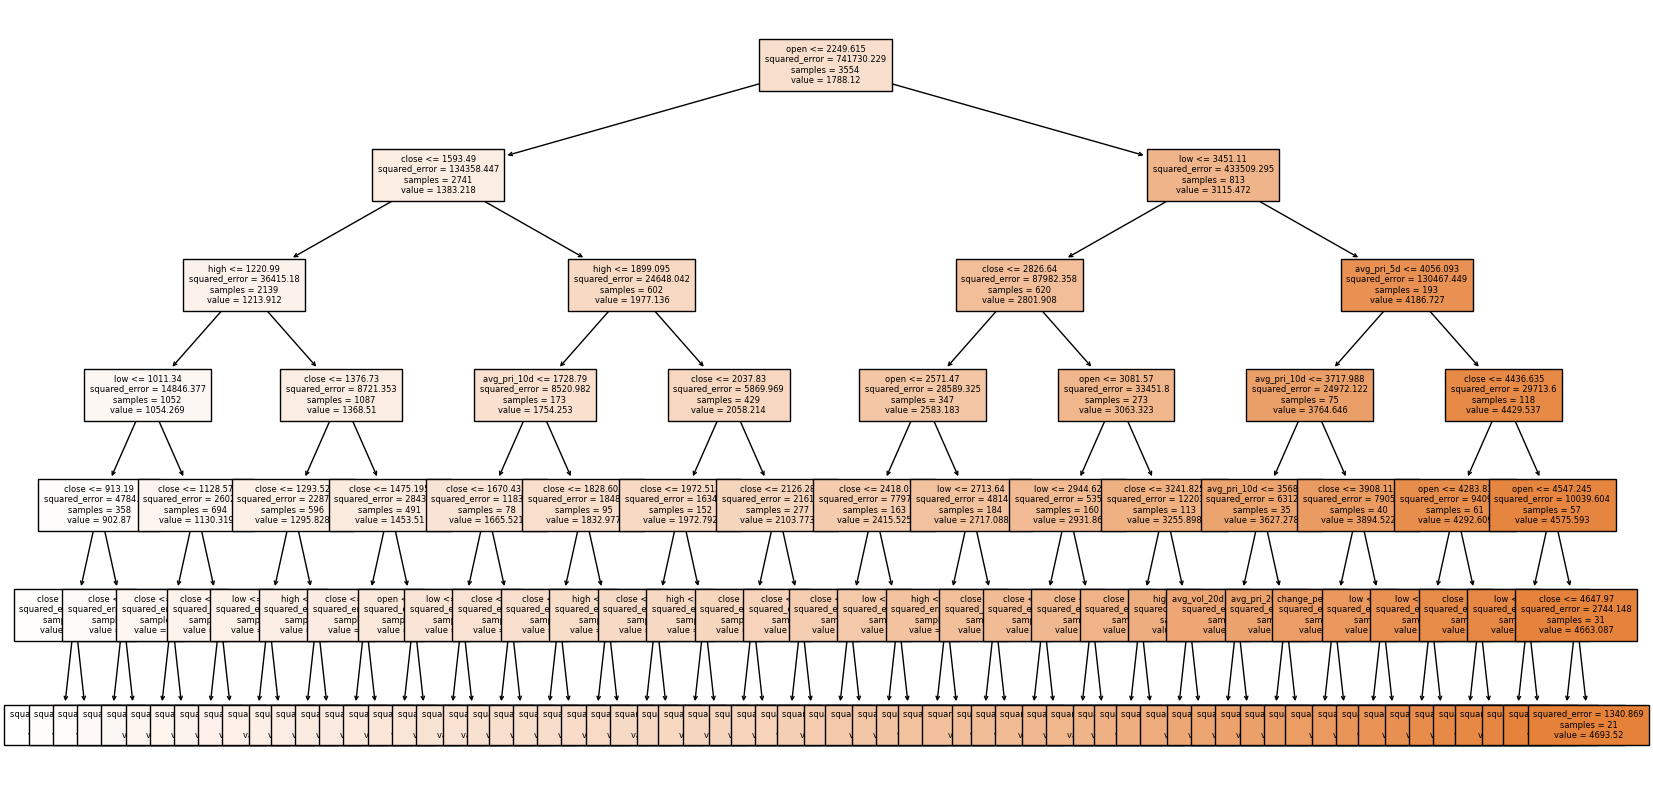

In [52]:
plt.figure(figsize=(20, 10))
tree.plot_tree(rf.estimators_[0], filled=True, feature_names=['open','high','close','low','volume','change_percent','avg_vol_20d','avg_pri_5d','avg_pri_10d','avg_pri_20d'], fontsize=6)
plt.show()

From the plot above, we can see the decision-making process of a single tree within the ensemble. By changing the parameter of **rf.estimators_**, we can see other trees.

## 7. Conclusion ##

The random forest technique performs well in stock market prediction, specific to next-day close price. These four prediction models all reach above 0.94 $R^2$ score. **Average closing price of the past 20 days** and **close price today** significantly contribute to the next-day close price prediction. 

Our project verified again that the $R^2$ score is a better indicator to measure model performance. Mean Absolute Error, Mean Squared Error, and Root Mean Square Error can be greatly influenced by the original data and are not suitable for comparing the predictive performance of different datasets.

Our project also verified again that the performance of random forest models may depend on the maximum depth of each tree and the total number of trees in the forest. As the number of trees increases, the performance may not be significantly better but will cause more computational cost (Oshiro et al., 2012). Limited tree depth may achieve excellent performance (Zhou & Mentch, 2022). The best maximum depth and tree number depend on the specific dataset and research question. We should test for optimal parameters again when meet a new situation.

## Reference ##

- Breiman, L. (1996). Bagging predictors. Machine Learning, 24(2), 123–140.
- Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32. https://doi.org/10.1023/a:1010933404324
- Chicco, D., Warrens, M. J., & Jurman, G. (2021). The coefficient of determination R-squared is more informative than SMAPE, MAE, MAPE, MSE and RMSE in regression analysis evaluation. PeerJ Computer Science, 7(5), e623. https://doi.org/10.7717/peerj-cs.623
- Kern, C., Klausch, T., & Kreuter, F. (2019). Tree-based Machine Learning Methods for Survey Research. DOAJ (DOAJ: Directory of Open Access Journals), 13(1), 73–93.
- N. J. D. Nagelkerke. (1991). A Note on a General Definition of the Coefficient of Determination. Biometrika, 78(3), 691. https://doi.org/10.2307/2337038
- Oshiro, T. M., Perez, P. S., & Baranauskas, J. A. (2012). How Many Trees in a Random Forest? Machine Learning and Data Mining in Pattern Recognition, 7376, 154–168. https://doi.org/10.1007/978-3-642-31537-4_13
- Zhou, S., & Mentch, L. (2022). Trees, forests, chickens, and eggs: when and why to prune trees in a random forest. Statistical Analysis and Data Mining: The ASA Data Science Journal, 16(1), 45–64. https://doi.org/10.1002/sam.11594
